# Introduction aux RNN pour les Séries Temporelles

## Objectifs de ce notebook

Dans ce notebook, nous allons explorer l'application des architectures récurrentes aux **séries temporelles** :

1. **RNN Simple** - L'architecture de base pour les séquences temporelles
2. **LSTM (Long Short-Term Memory)** - Pour capturer les dépendances à long terme
3. **GRU (Gated Recurrent Unit)** - Version optimisée et efficace

Nous travaillerons sur un problème de **prédiction de consommation énergétique**, un cas d'usage classique en industrie.

## Pourquoi les RNN pour les séries temporelles ?

Les séries temporelles ont des caractéristiques uniques :
- **Dépendance temporelle** : Les valeurs passées influencent les valeurs futures
- **Tendances** : Évolution à long terme (croissance, décroissance)
- **Saisonnalité** : Patterns qui se répètent (jour/nuit, semaine, saison)
- **Cycles** : Variations périodiques

**Applications** :
- 📈 **Finance** : Prédiction de prix d'actions, taux de change
- ⚡ **Énergie** : Prévision de consommation électrique
- 🌡️ **Météo** : Prévisions météorologiques
- 🏭 **Industrie** : Maintenance prédictive, optimisation de production
- 🏥 **Santé** : Surveillance de signaux vitaux, prédiction d'épidémies

## 1. Imports et configuration

In [3]:
# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.callbacks import Callback, EarlyStopping

# Sklearn pour normalisation et métriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")
    print("Utilisation du CPU par défaut")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

2025-11-04 16:06:15.005236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 16:06:15.517957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 16:06:16.983303: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU(s) détecté(s): 1 - Croissance mémoire activée

TensorFlow version: 2.20.0
Keras version: 3.11.3


## 2. Génération et Exploration des Données

### 2.1 Création d'une série temporelle synthétique

Nous allons générer une série temporelle de **consommation énergétique** avec plusieurs composantes réalistes :
- **Tendance** : Croissance graduelle de la consommation
- **Saisonnalité quotidienne** : Pics le matin et le soir
- **Saisonnalité hebdomadaire** : Plus faible consommation le weekend
- **Bruit** : Variations aléatoires

In [4]:
# Paramètres de génération
n_hours = 24 * 365 * 2  # 2 ans de données horaires
time = np.arange(n_hours)

# Composante 1: Tendance (croissance légère)
trend = 0.01 * time

# Composante 2: Saisonnalité annuelle (été/hiver)
seasonal_yearly = 30 * np.sin(2 * np.pi * time / (24 * 365))

# Composante 3: Saisonnalité quotidienne (jour/nuit)
seasonal_daily = 20 * np.sin(2 * np.pi * time / 24) + 10 * np.sin(4 * np.pi * time / 24)

# Composante 4: Saisonnalité hebdomadaire (weekend)
seasonal_weekly = 15 * np.sin(2 * np.pi * time / (24 * 7))

# Composante 5: Bruit aléatoire
np.random.seed(42)
noise = np.random.normal(0, 5, n_hours)

# Série temporelle finale
base_consumption = 100
energy_consumption = (base_consumption + trend + seasonal_yearly + 
                     seasonal_daily + seasonal_weekly + noise)

# Créer un DataFrame
dates = pd.date_range(start='2022-01-01', periods=n_hours, freq='H')
df = pd.DataFrame({
    'datetime': dates,
    'consumption': energy_consumption
})

print(f"{'='*70}")
print(f"INFORMATIONS SUR LES DONNÉES")
print(f"{'='*70}")
print(f"Nombre total d'observations: {len(df):,}")
print(f"Période: {df['datetime'].min()} à {df['datetime'].max()}")
print(f"Fréquence: Horaire")
print(f"\nStatistiques de consommation (kWh):")
print(df['consumption'].describe())
print(f"{'='*70}")

INFORMATIONS SUR LES DONNÉES
Nombre total d'observations: 17,520
Période: 2022-01-01 00:00:00 à 2023-12-31 23:00:00
Fréquence: Horaire

Statistiques de consommation (kWh):
count    17520.000000
mean       187.643864
std         50.579199
min         59.540848
25%        143.818776
50%        187.453789
75%        231.346190
max        319.745631
Name: consumption, dtype: float64


### 2.2 Visualisation de la série temporelle complète

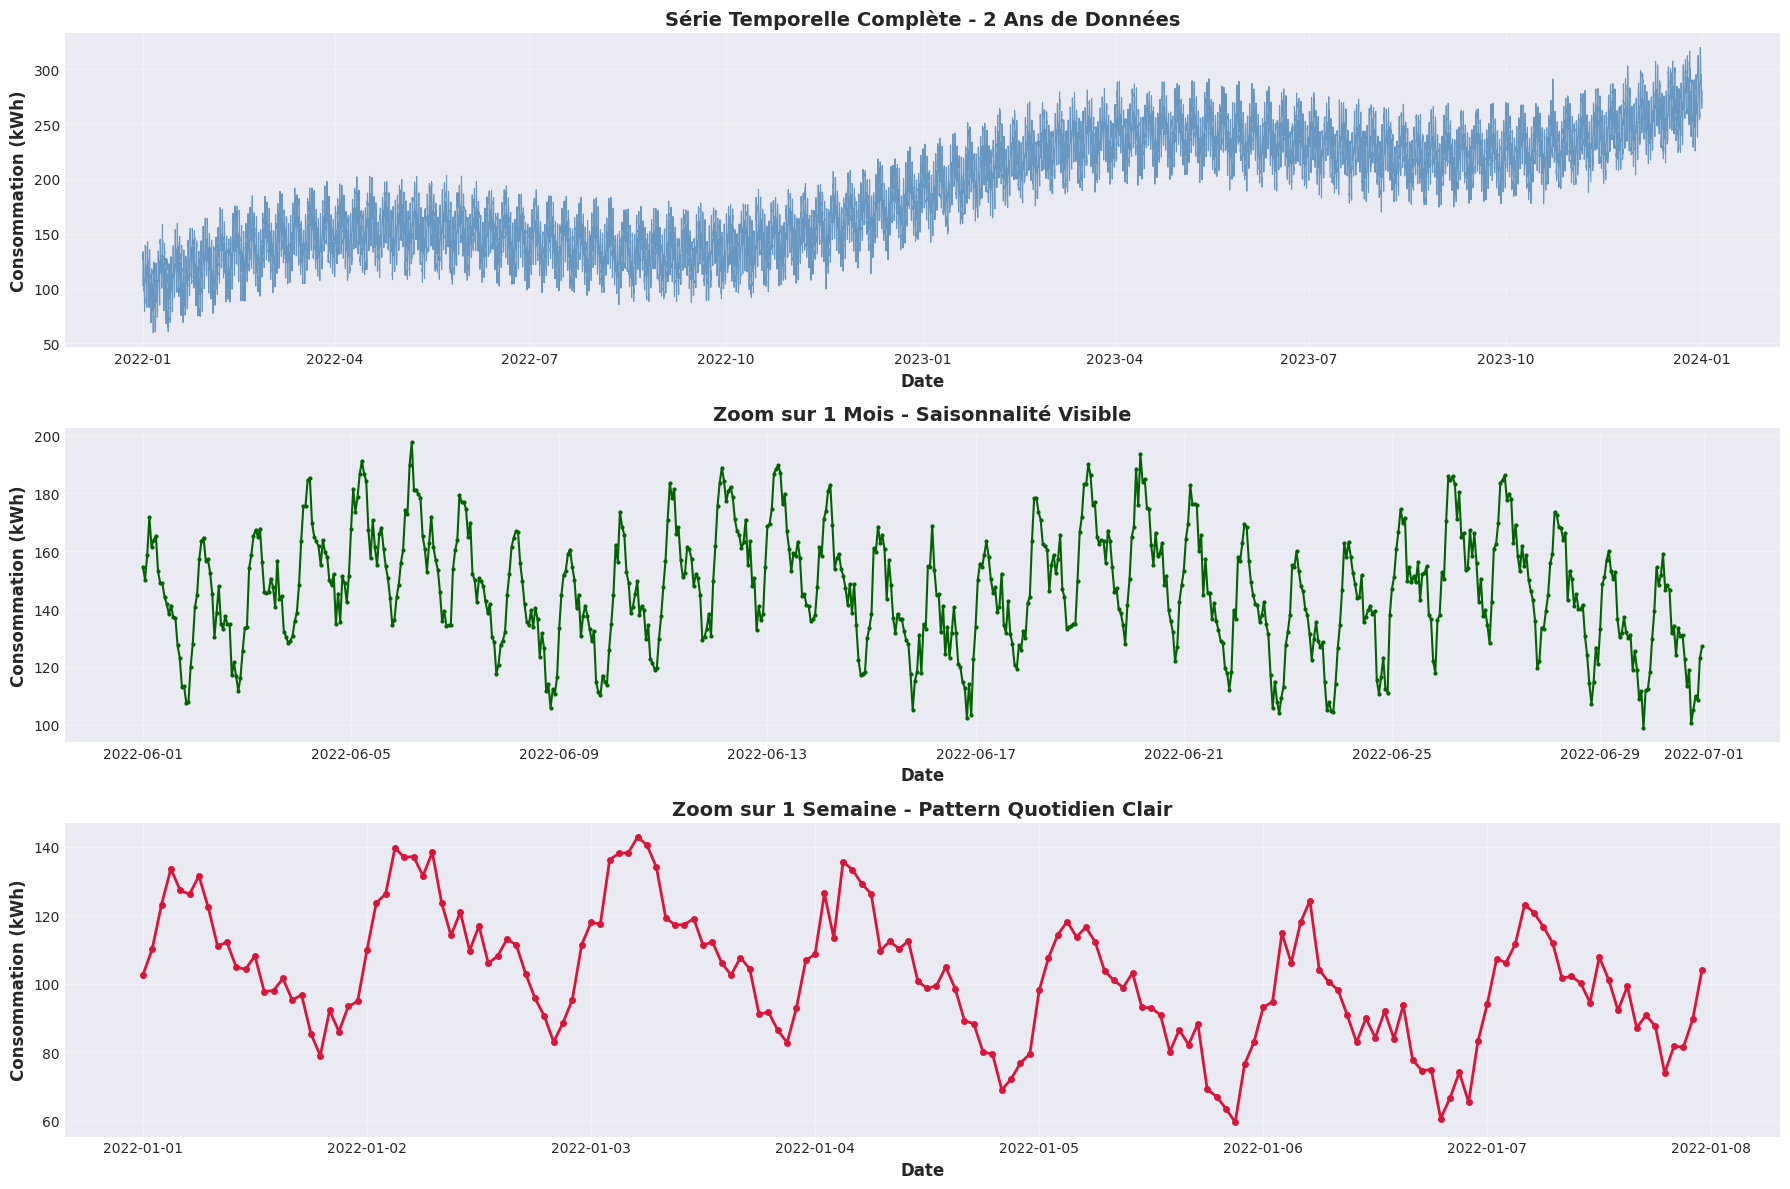

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# Vue complète (2 ans)
axes[0].plot(df['datetime'], df['consumption'], linewidth=0.8, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('Série Temporelle Complète - 2 Ans de Données', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Zoom sur 1 mois
month_data = df[df['datetime'].dt.month == 6].iloc[:24*30]
axes[1].plot(month_data['datetime'], month_data['consumption'], 
            linewidth=1.5, color='darkgreen', marker='o', markersize=2)
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('Zoom sur 1 Mois - Saisonnalité Visible', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

# Zoom sur 1 semaine
week_data = df.iloc[:24*7]
axes[2].plot(week_data['datetime'], week_data['consumption'], 
            linewidth=2, color='crimson', marker='o', markersize=4)
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[2].set_title('Zoom sur 1 Semaine - Pattern Quotidien Clair', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Analyse des patterns temporels

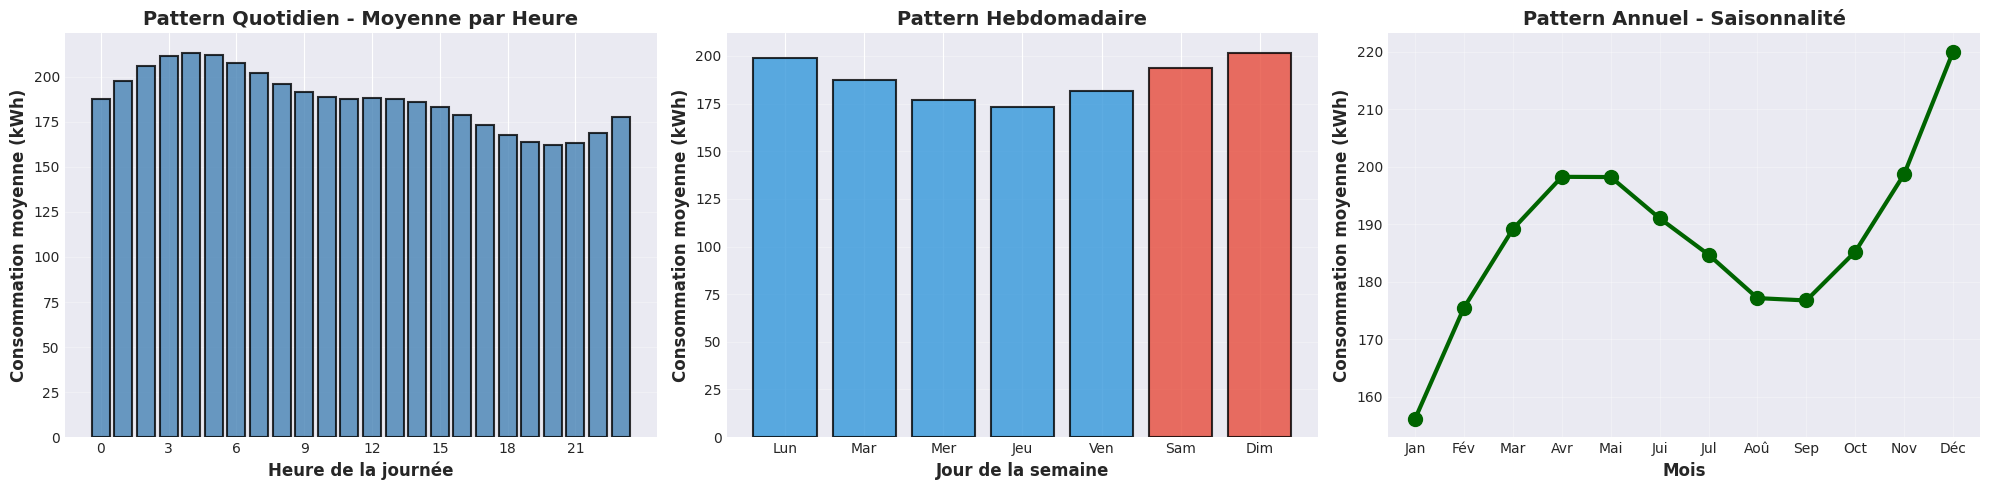


📊 Observations:
  - Pic de consommation quotidien: 4h (213.5 kWh)
  - Creux de consommation quotidien: 20h (161.9 kWh)
  - Consommation plus élevée en semaine (Lun-Ven) vs weekend
  - Pic saisonnier: Déc (220.0 kWh)


In [6]:
# Extraction des features temporelles
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Pattern horaire (moyenne par heure de la journée)
hourly_avg = df.groupby('hour')['consumption'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, color='steelblue', 
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[0].set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Consommation moyenne (kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('Pattern Quotidien - Moyenne par Heure', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xticks(range(0, 24, 3))

# Pattern hebdomadaire
weekly_avg = df.groupby('day_of_week')['consumption'].mean()
day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
colors_week = ['#3498db' if i < 5 else '#e74c3c' for i in range(7)]
axes[1].bar(range(7), weekly_avg.values, color=colors_week, 
           edgecolor='black', linewidth=1.5, alpha=0.8)
axes[1].set_xlabel('Jour de la semaine', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Consommation moyenne (kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('Pattern Hebdomadaire', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(day_names)

# Pattern mensuel
monthly_avg = df.groupby('month')['consumption'].mean()
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jui', 
               'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
axes[2].plot(monthly_avg.index, monthly_avg.values, marker='o', 
            linewidth=3, markersize=10, color='darkgreen')
axes[2].set_xlabel('Mois', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Consommation moyenne (kWh)', fontsize=12, fontweight='bold')
axes[2].set_title('Pattern Annuel - Saisonnalité', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3)
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names)

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print(f"  - Pic de consommation quotidien: {hourly_avg.idxmax()}h ({hourly_avg.max():.1f} kWh)")
print(f"  - Creux de consommation quotidien: {hourly_avg.idxmin()}h ({hourly_avg.min():.1f} kWh)")
print(f"  - Consommation plus élevée en semaine (Lun-Ven) vs weekend")
print(f"  - Pic saisonnier: {month_names[monthly_avg.idxmax()-1]} ({monthly_avg.max():.1f} kWh)")

## 3. Préparation des Données pour les RNN

### 3.1 Concepts clés pour les séries temporelles

**Fenêtre glissante (Sliding Window)** :
- Nous utilisons les `n` dernières observations pour prédire la prochaine valeur
- Exemple: Les 24 dernières heures → Prédire l'heure suivante

```
Données: [h1, h2, h3, h4, h5, h6, h7, h8, ...]
         
X (input)           y (target)
[h1, h2, h3]    →      h4
[h2, h3, h4]    →      h5
[h3, h4, h5]    →      h6
...
```

**Normalisation** :
- Les RNN sont sensibles à l'échelle des données
- Nous normalisons entre 0 et 1 avec MinMaxScaler

In [7]:
# Paramètres
LOOKBACK = 24 * 7  # 7 jours (168 heures) pour prédire 1 heure
TRAIN_SPLIT = 0.7  # 70% train, 15% validation, 15% test
VAL_SPLIT = 0.85

print(f"Configuration de la fenêtre temporelle:")
print(f"  - Lookback: {LOOKBACK} heures ({LOOKBACK//24} jours)")
print(f"  - Prédiction: 1 heure à l'avance")
print(f"  - Split: {TRAIN_SPLIT*100:.0f}% train / {(VAL_SPLIT-TRAIN_SPLIT)*100:.0f}% val / {(1-VAL_SPLIT)*100:.0f}% test")

Configuration de la fenêtre temporelle:
  - Lookback: 168 heures (7 jours)
  - Prédiction: 1 heure à l'avance
  - Split: 70% train / 15% val / 15% test


### 3.2 Normalisation des données


Tailles des ensembles:
  Train: 12,264 observations (511 jours)
  Val:   2,628 observations (110 jours)
  Test:  2,628 observations (110 jours)


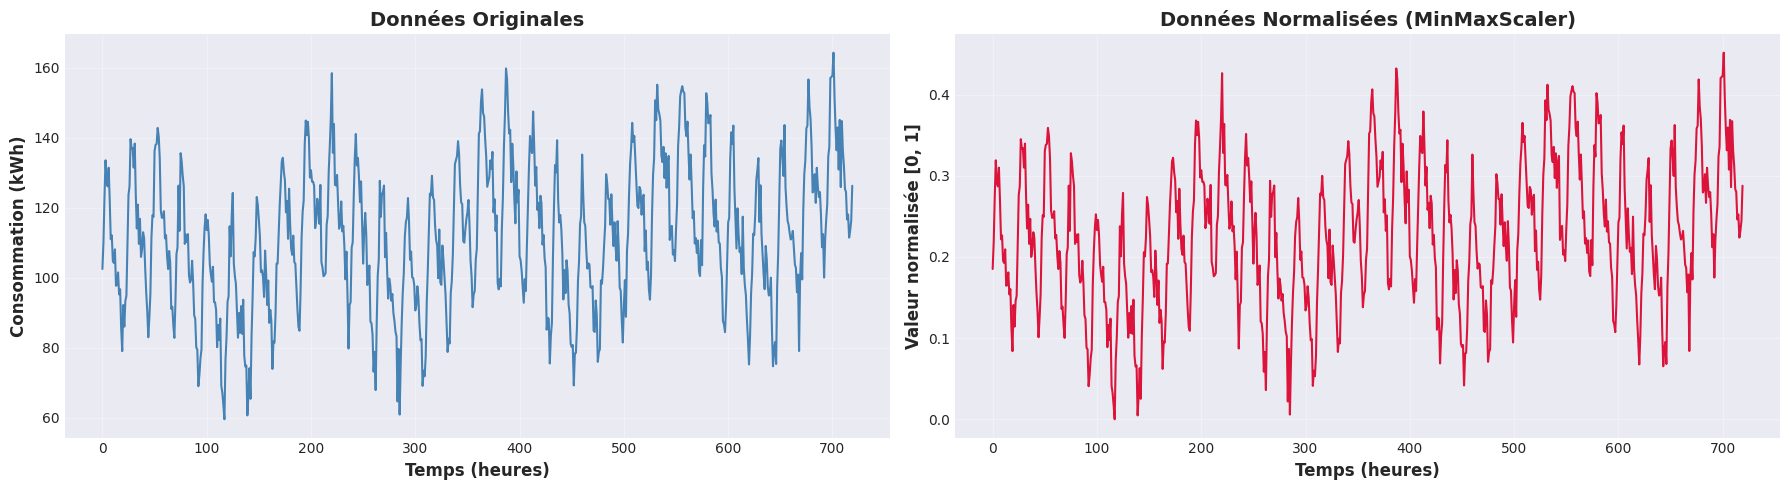


✅ Normalisation effectuée:
  Min normalisé: 0.0000
  Max normalisé: 1.0000


In [8]:
# Extraction des valeurs
data = df['consumption'].values.reshape(-1, 1)

# Division train/val/test
train_size = int(len(data) * TRAIN_SPLIT)
val_size = int(len(data) * VAL_SPLIT)

train_data = data[:train_size]
val_data = data[train_size:val_size]
test_data = data[val_size:]

print(f"\nTailles des ensembles:")
print(f"  Train: {len(train_data):,} observations ({len(train_data)/24:.0f} jours)")
print(f"  Val:   {len(val_data):,} observations ({len(val_data)/24:.0f} jours)")
print(f"  Test:  {len(test_data):,} observations ({len(test_data)/24:.0f} jours)")

# Normalisation (fit uniquement sur train pour éviter le data leakage)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

# Visualisation avant/après normalisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

sample_size = 24 * 30  # 1 mois
ax1.plot(data[:sample_size], linewidth=1.5, color='steelblue')
ax1.set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
ax1.set_title('Données Originales', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

ax2.plot(train_scaled[:sample_size], linewidth=1.5, color='crimson')
ax2.set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valeur normalisée [0, 1]', fontsize=12, fontweight='bold')
ax2.set_title('Données Normalisées (MinMaxScaler)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✅ Normalisation effectuée:")
print(f"  Min normalisé: {train_scaled.min():.4f}")
print(f"  Max normalisé: {train_scaled.max():.4f}")

### 3.3 Création des séquences (Sliding Window)


FORMES DES DONNÉES APRÈS CRÉATION DES SÉQUENCES
X_train: (12096, 168, 1) - (12096 séquences, 168 timesteps, 1 feature)
y_train: (12096,) - (12096 valeurs cibles)

X_val:   (2460, 168, 1)
y_val:   (2460,)

X_test:  (2460, 168, 1)
y_test:  (2460,)


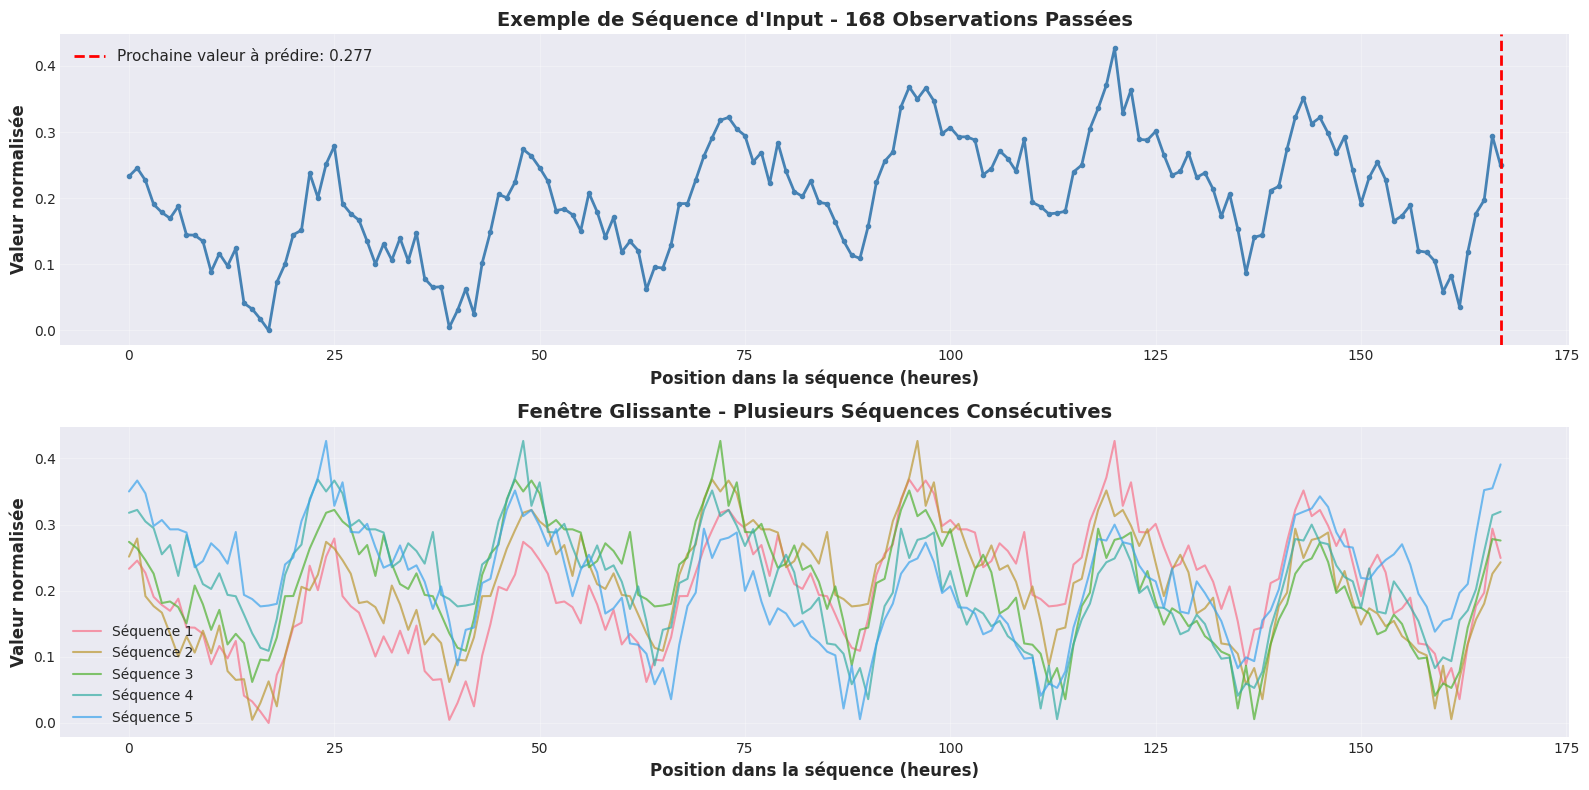

In [9]:
def create_sequences(data, lookback):
    """
    Crée des séquences avec fenêtre glissante.
    
    Args:
        data: Array de données normalisées
        lookback: Nombre d'observations passées à utiliser
    
    Returns:
        X: Séquences d'input (n_samples, lookback, 1)
        y: Valeurs cibles (n_samples, 1)
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Création des séquences
X_train, y_train = create_sequences(train_scaled, LOOKBACK)
X_val, y_val = create_sequences(val_scaled, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, LOOKBACK)

# Reshape pour RNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\n{'='*70}")
print(f"FORMES DES DONNÉES APRÈS CRÉATION DES SÉQUENCES")
print(f"{'='*70}")
print(f"X_train: {X_train.shape} - ({X_train.shape[0]} séquences, {X_train.shape[1]} timesteps, {X_train.shape[2]} feature)")
print(f"y_train: {y_train.shape} - ({y_train.shape[0]} valeurs cibles)")
print(f"\nX_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"\nX_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")
print(f"{'='*70}")

# Visualisation d'un exemple de séquence
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Exemple de séquence d'input
sample_idx = 100
ax1.plot(range(LOOKBACK), X_train[sample_idx, :, 0], 
        marker='o', linewidth=2, markersize=3, color='steelblue')
ax1.axvline(x=LOOKBACK-1, color='red', linestyle='--', linewidth=2, 
           label=f'Prochaine valeur à prédire: {y_train[sample_idx]:.3f}')
ax1.set_xlabel('Position dans la séquence (heures)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Valeur normalisée', fontsize=12, fontweight='bold')
ax1.set_title(f'Exemple de Séquence d\'Input - {LOOKBACK} Observations Passées', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plusieurs exemples pour montrer le glissement
n_examples = 5
for i in range(n_examples):
    idx = sample_idx + i * 24  # Un exemple par jour
    ax2.plot(range(LOOKBACK), X_train[idx, :, 0], 
            alpha=0.7, linewidth=1.5, label=f'Séquence {i+1}')
ax2.set_xlabel('Position dans la séquence (heures)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Valeur normalisée', fontsize=12, fontweight='bold')
ax2.set_title('Fenêtre Glissante - Plusieurs Séquences Consécutives', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Callback pour visualisation en temps réel

In [10]:
class LivePlotCallback(Callback):
    """
    Callback pour visualiser les métriques d'entraînement en temps réel.
    """
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.val_loss = []
        self.mae = []
        self.val_mae = []
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.mae.append(logs.get('mae'))
        self.val_mae.append(logs.get('val_mae'))
        
        clear_output(wait=True)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Loss (MSE)
        ax1.plot(self.epochs, self.loss, 'o-', label='Loss Train', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax1.plot(self.epochs, self.val_loss, 's-', label='Loss Validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
        ax1.set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(alpha=0.3)
        
        # MAE
        ax2.plot(self.epochs, self.mae, 'o-', label='MAE Train', 
                linewidth=2, markersize=8, color='#2E86AB')
        ax2.plot(self.epochs, self.val_mae, 's-', label='MAE Validation', 
                linewidth=2, markersize=8, color='#A23B72')
        ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax2.set_ylabel('MAE', fontsize=12, fontweight='bold')
        ax2.set_title('Évolution de la MAE', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nEpoch {epoch + 1}/{self.params['epochs']}")
        print(f"Loss: {logs.get('loss'):.6f} - MAE: {logs.get('mae'):.6f}")
        print(f"Val Loss: {logs.get('val_loss'):.6f} - Val MAE: {logs.get('val_mae'):.6f}")

---

# PARTIE 1 : RNN SIMPLE

## 5. Architecture RNN pour Séries Temporelles

### Adaptation du RNN aux séries temporelles

Pour les séries temporelles, le RNN traite chaque timestep séquentiellement :

```
Entrée (168 heures)  →  RNN  →  Sortie (1 valeur)
[t-167, ..., t-1]    →  [64]  →  prédiction de t
```

**Architecture** :
- Input: (batch_size, 168, 1) - 168 heures, 1 feature
- SimpleRNN: 64 unités
- Dense: 1 unité (régression)

**Loss fonction** : MSE (Mean Squared Error) - standard pour la régression

**Métriques** : MAE (Mean Absolute Error) - interprétable en kWh

### 5.1 Construction du modèle RNN

In [11]:
def create_rnn_model(lookback):
    """
    Crée un modèle RNN simple pour la prédiction de séries temporelles.
    """
    model = keras.Sequential([
        # Couche RNN
        layers.SimpleRNN(64, input_shape=(lookback, 1), name='simple_rnn'),
        
        # Dropout pour régularisation
        layers.Dropout(0.2, name='dropout'),
        
        # Couche de sortie (régression)
        layers.Dense(1, name='output')
    ])
    
    return model

# Création du modèle
rnn_model = create_rnn_model(LOOKBACK)

# Affichage de l'architecture
rnn_model.summary()

# Comptage des paramètres
total_params_rnn = rnn_model.count_params()
print(f"\n{'='*60}")
print(f"Total de paramètres RNN: {total_params_rnn:,}")
print(f"{'='*60}")

I0000 00:00:1762268779.134442   12851 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)


Total de paramètres RNN: 4,289


### 5.2 Compilation du modèle RNN

In [12]:
# Compilation avec métriques adaptées aux séries temporelles
rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("✅ Modèle RNN compilé avec succès !")
print(f"Optimiseur: Adam (lr=0.001)")
print(f"Loss: MSE (Mean Squared Error)")
print(f"Métriques: MAE (Mean Absolute Error)")

✅ Modèle RNN compilé avec succès !
Optimiseur: Adam (lr=0.001)
Loss: MSE (Mean Squared Error)
Métriques: MAE (Mean Absolute Error)


### 5.3 Entraînement du modèle RNN

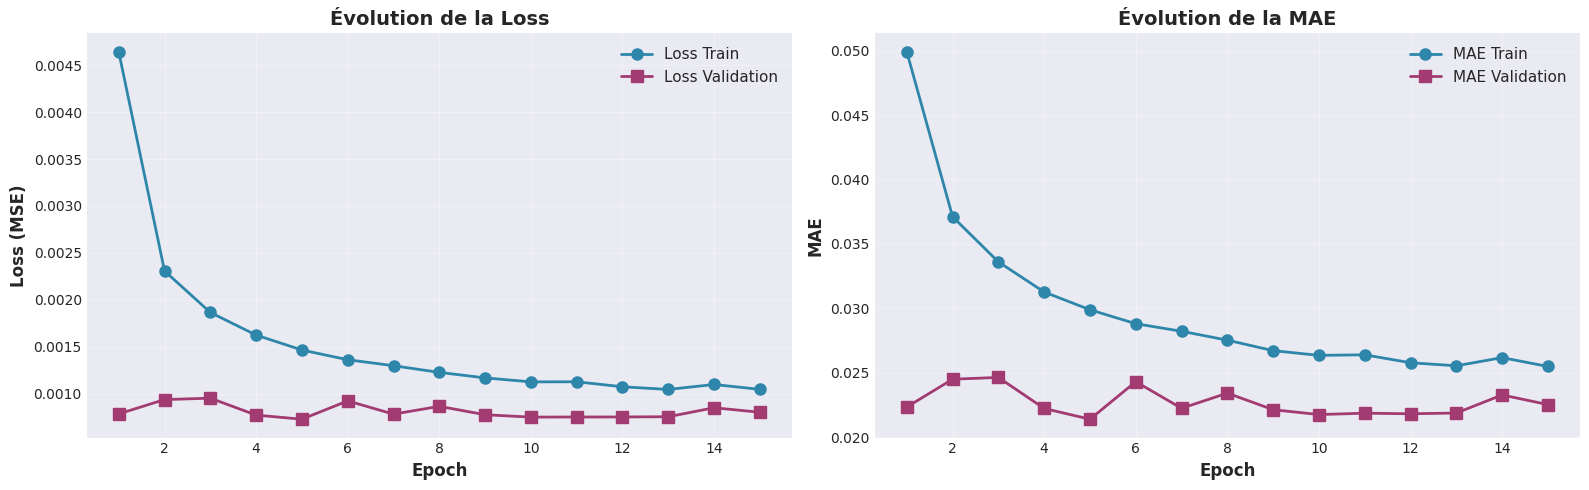


Epoch 15/50
Loss: 0.001044 - MAE: 0.025490
Val Loss: 0.000800 - Val MAE: 0.022531

✅ Entraînement terminé ! (Early stopping à l'epoch 15)


In [13]:
# Callbacks
live_plot_rnn = LivePlotCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement
print("🚀 Début de l'entraînement du modèle RNN...\n")

history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[live_plot_rnn, early_stopping],
    verbose=0
)

print(f"\n✅ Entraînement terminé ! (Early stopping à l'epoch {len(history_rnn.history['loss'])})")

### 5.4 Évaluation du modèle RNN

In [14]:
# Prédictions sur le test set
y_pred_rnn_scaled = rnn_model.predict(X_test, verbose=0)

# Dénormalisation pour obtenir les vraies valeurs
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn_original = scaler.inverse_transform(y_pred_rnn_scaled)

# Calcul des métriques
mse_rnn = mean_squared_error(y_test_original, y_pred_rnn_original)
mae_rnn = mean_absolute_error(y_test_original, y_pred_rnn_original)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_original, y_pred_rnn_original)

print("="*70)
print("RÉSULTATS FINAUX - MODÈLE RNN")
print("="*70)
print(f"MSE (Mean Squared Error):  {mse_rnn:.2f}")
print(f"MAE (Mean Absolute Error): {mae_rnn:.2f} kWh")
print(f"RMSE (Root MSE):           {rmse_rnn:.2f} kWh")
print(f"R² Score:                  {r2_rnn:.4f}")
print(f"\n📊 Interprétation: En moyenne, l'erreur de prédiction est de {mae_rnn:.2f} kWh")
print("="*70)

RÉSULTATS FINAUX - MODÈLE RNN
MSE (Mean Squared Error):  41.62
MAE (Mean Absolute Error): 5.14 kWh
RMSE (Root MSE):           6.45 kWh
R² Score:                  0.9376

📊 Interprétation: En moyenne, l'erreur de prédiction est de 5.14 kWh


### 5.5 Visualisation des prédictions RNN

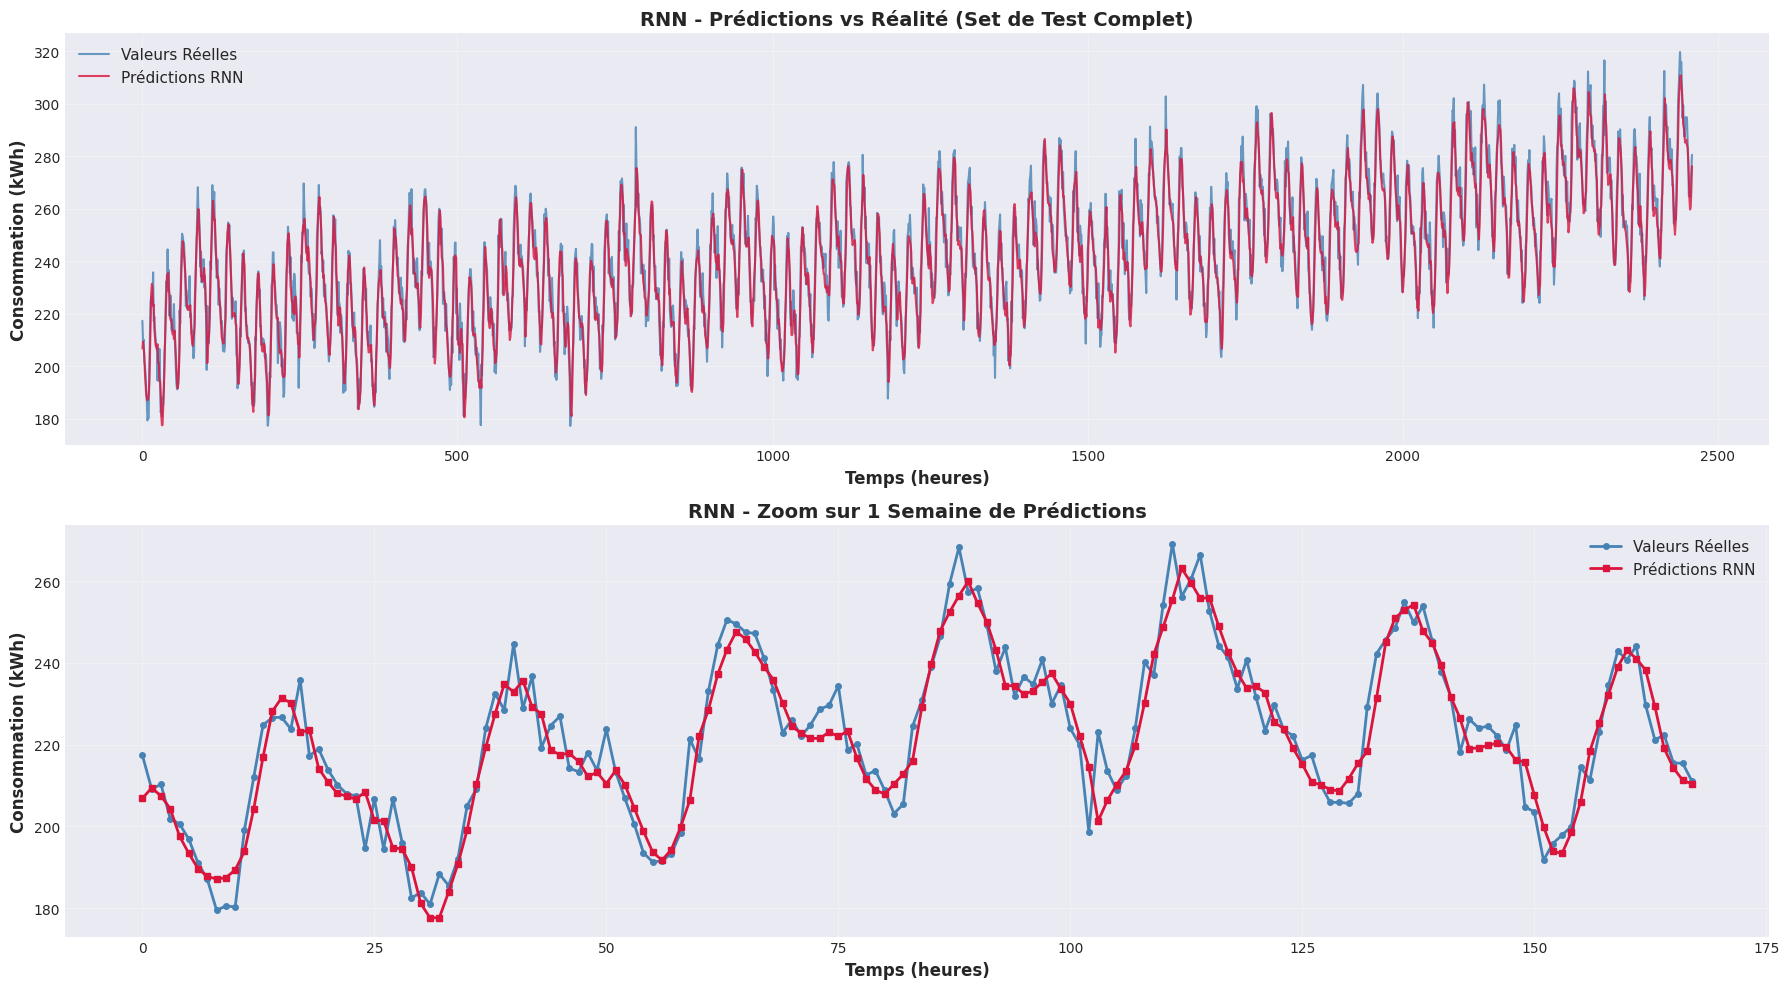

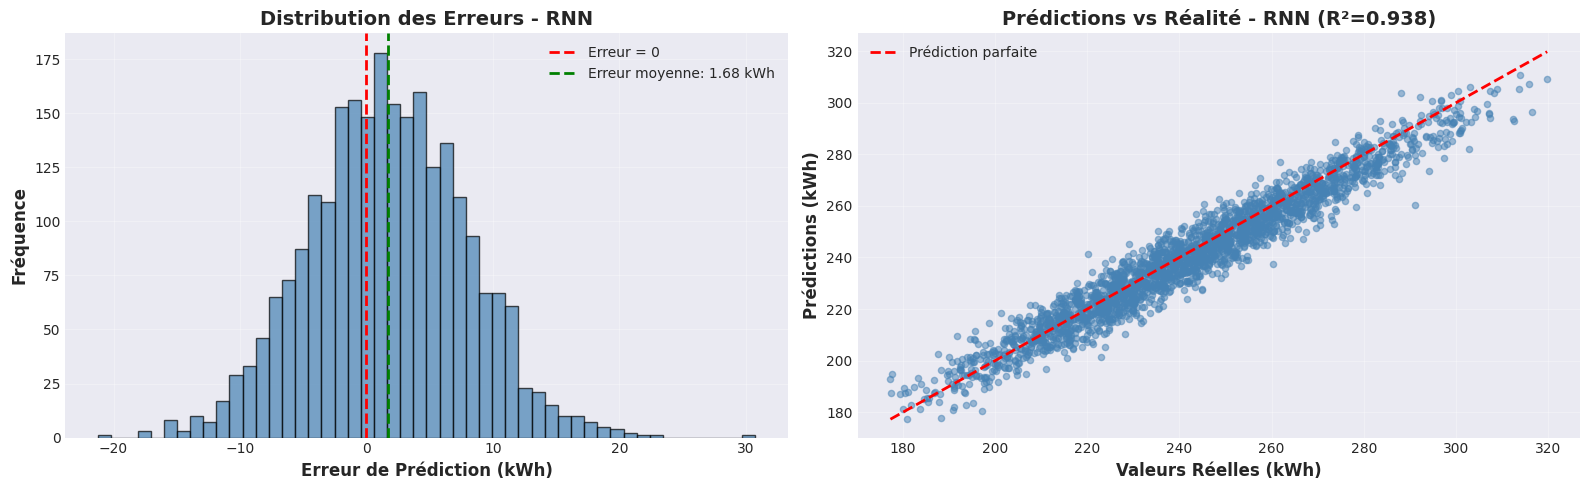

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Vue d'ensemble (tous les tests)
axes[0].plot(y_test_original, label='Valeurs Réelles', linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].plot(y_pred_rnn_original, label='Prédictions RNN', linewidth=1.5, color='crimson', alpha=0.8)
axes[0].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('RNN - Prédictions vs Réalité (Set de Test Complet)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Zoom sur une semaine
zoom_size = 24 * 7  # 1 semaine
axes[1].plot(range(zoom_size), y_test_original[:zoom_size], 
            label='Valeurs Réelles', linewidth=2, color='steelblue', marker='o', markersize=4)
axes[1].plot(range(zoom_size), y_pred_rnn_original[:zoom_size], 
            label='Prédictions RNN', linewidth=2, color='crimson', marker='s', markersize=4)
axes[1].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('RNN - Zoom sur 1 Semaine de Prédictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution des erreurs
errors_rnn = y_test_original.flatten() - y_pred_rnn_original.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Histogramme des erreurs
ax1.hist(errors_rnn, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
ax1.axvline(x=errors_rnn.mean(), color='green', linestyle='--', linewidth=2, 
           label=f'Erreur moyenne: {errors_rnn.mean():.2f} kWh')
ax1.set_xlabel('Erreur de Prédiction (kWh)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Erreurs - RNN', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Scatter plot: prédictions vs réalité
ax2.scatter(y_test_original, y_pred_rnn_original, alpha=0.5, s=20, color='steelblue')
ax2.plot([y_test_original.min(), y_test_original.max()], 
        [y_test_original.min(), y_test_original.max()], 
        'r--', linewidth=2, label='Prédiction parfaite')
ax2.set_xlabel('Valeurs Réelles (kWh)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prédictions (kWh)', fontsize=12, fontweight='bold')
ax2.set_title(f'Prédictions vs Réalité - RNN (R²={r2_rnn:.3f})', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# PARTIE 2 : LSTM

## 6. Architecture LSTM pour Séries Temporelles

### Pourquoi LSTM pour les séries temporelles ?

Les **LSTM** sont particulièrement efficaces pour les séries temporelles car :
- ✅ Ils capturent les **dépendances à long terme** (tendances)
- ✅ Ils gèrent mieux les **variations temporelles** complexes
- ✅ Ils sont **robustes au problème du gradient qui disparaît**

**Applications** :
- Prédiction de prix d'actions (patterns sur plusieurs jours/semaines)
- Prévisions météorologiques (saisonnalité complexe)
- Détection d'anomalies dans les capteurs IoT

### 6.1 Construction du modèle LSTM

In [16]:
def create_lstm_model(lookback):
    """
    Crée un modèle LSTM pour la prédiction de séries temporelles.
    """
    model = keras.Sequential([
        # Couche LSTM
        layers.LSTM(64, input_shape=(lookback, 1), name='lstm'),
        
        # Dropout pour régularisation
        layers.Dropout(0.2, name='dropout'),
        
        # Couche de sortie
        layers.Dense(1, name='output')
    ])
    
    return model

# Création du modèle
lstm_model = create_lstm_model(LOOKBACK)

# Affichage de l'architecture
lstm_model.summary()

# Comptage des paramètres
total_params_lstm = lstm_model.count_params()
print(f"\n{'='*60}")
print(f"Total de paramètres LSTM: {total_params_lstm:,}")
print(f"Ratio LSTM/RNN: {total_params_lstm/total_params_rnn:.2f}×")
print(f"{'='*60}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)


Total de paramètres LSTM: 16,961
Ratio LSTM/RNN: 3.95×


### 6.2 Compilation et entraînement du modèle LSTM

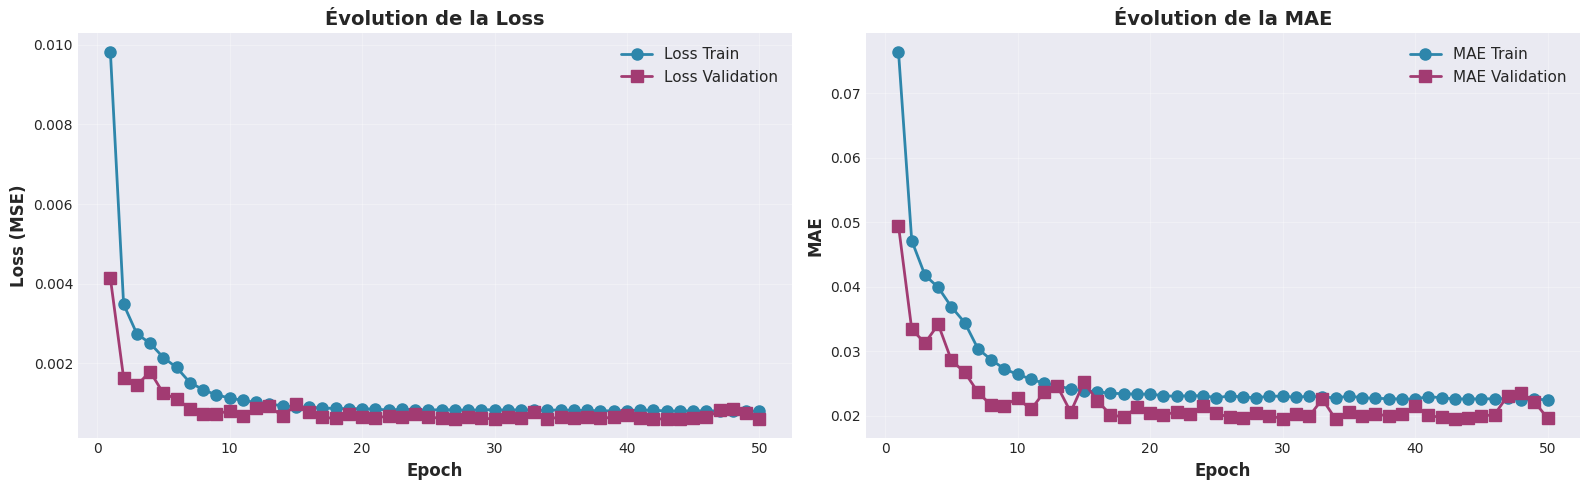


Epoch 50/50
Loss: 0.000807 - MAE: 0.022460
Val Loss: 0.000604 - Val MAE: 0.019608

✅ Entraînement terminé ! (Early stopping à l'epoch 50)


In [17]:
# Compilation
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("✅ Modèle LSTM compilé avec succès !")

# Callbacks
live_plot_lstm = LivePlotCallback()
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement
print("\n🚀 Début de l'entraînement du modèle LSTM...\n")

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[live_plot_lstm, early_stopping_lstm],
    verbose=0
)

print(f"\n✅ Entraînement terminé ! (Early stopping à l'epoch {len(history_lstm.history['loss'])})")

### 6.3 Évaluation du modèle LSTM

In [18]:
# Prédictions
y_pred_lstm_scaled = lstm_model.predict(X_test, verbose=0)
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm_scaled)

# Métriques
mse_lstm = mean_squared_error(y_test_original, y_pred_lstm_original)
mae_lstm = mean_absolute_error(y_test_original, y_pred_lstm_original)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_original, y_pred_lstm_original)

print("="*70)
print("RÉSULTATS FINAUX - MODÈLE LSTM")
print("="*70)
print(f"MSE (Mean Squared Error):  {mse_lstm:.2f}")
print(f"MAE (Mean Absolute Error): {mae_lstm:.2f} kWh")
print(f"RMSE (Root MSE):           {rmse_lstm:.2f} kWh")
print(f"R² Score:                  {r2_lstm:.4f}")
print(f"\n📊 Amélioration vs RNN: {((mae_rnn - mae_lstm)/mae_rnn * 100):.1f}% de réduction de la MAE")
print("="*70)

RÉSULTATS FINAUX - MODÈLE LSTM
MSE (Mean Squared Error):  33.02
MAE (Mean Absolute Error): 4.61 kWh
RMSE (Root MSE):           5.75 kWh
R² Score:                  0.9505

📊 Amélioration vs RNN: 10.3% de réduction de la MAE


### 6.4 Visualisation des prédictions LSTM

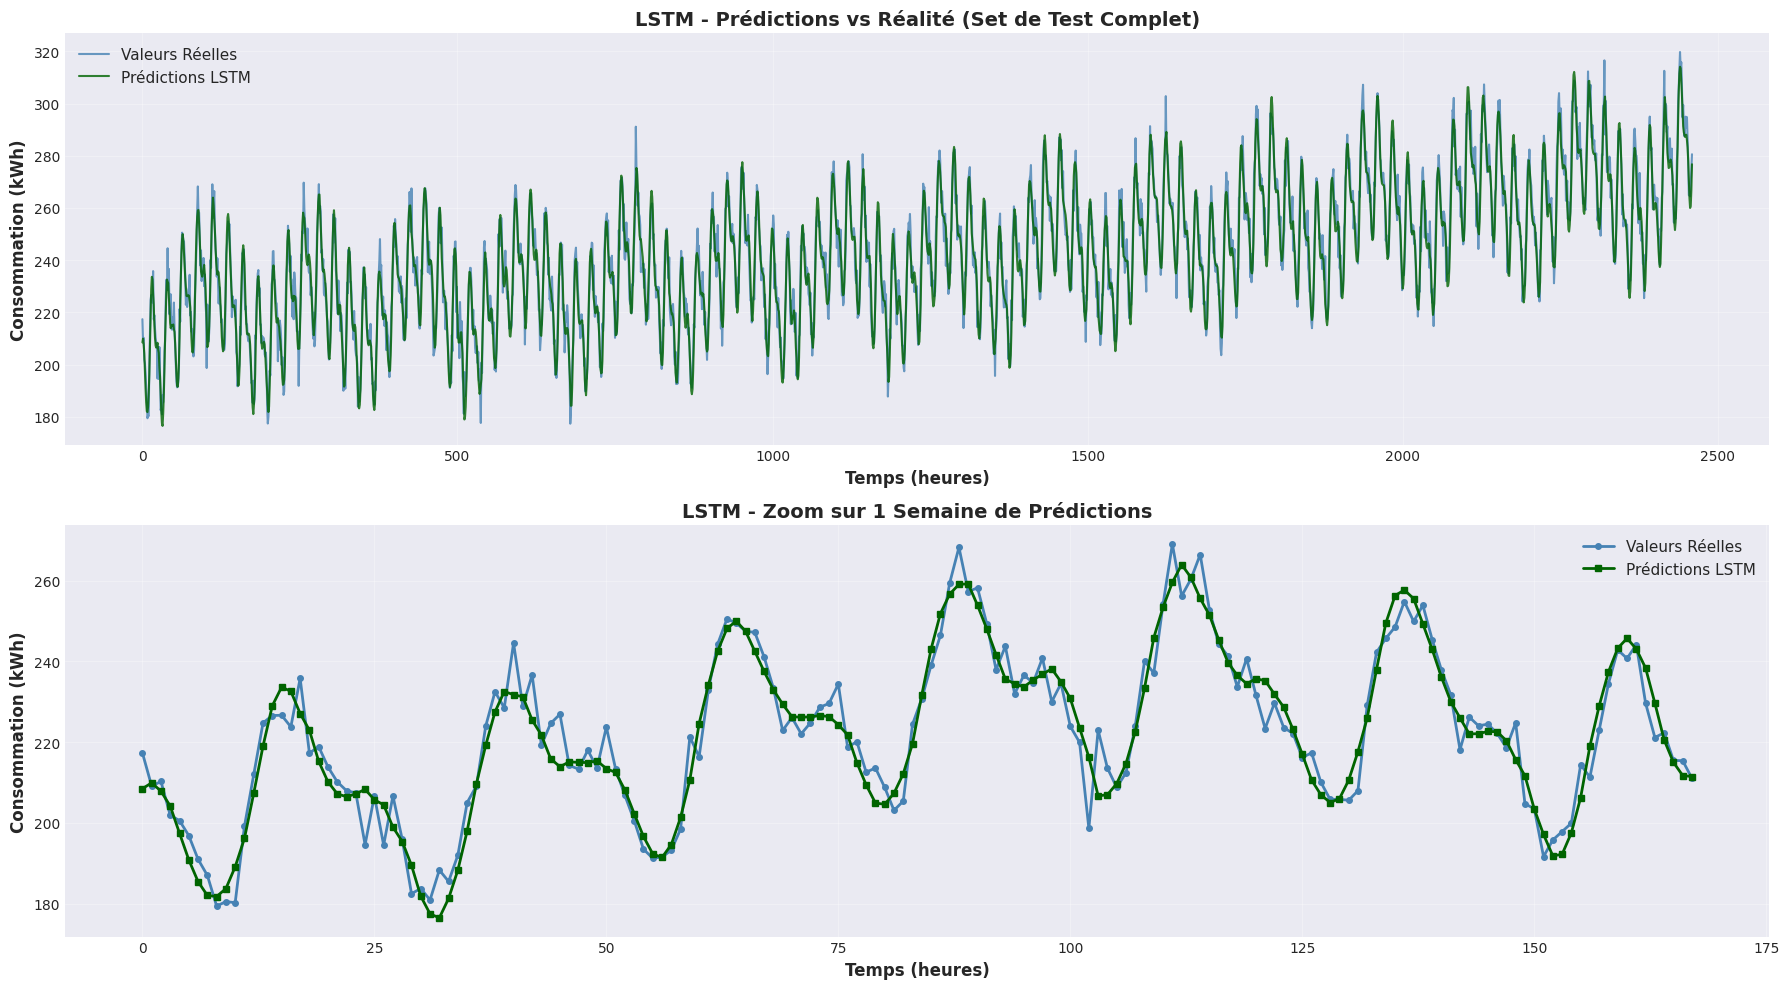

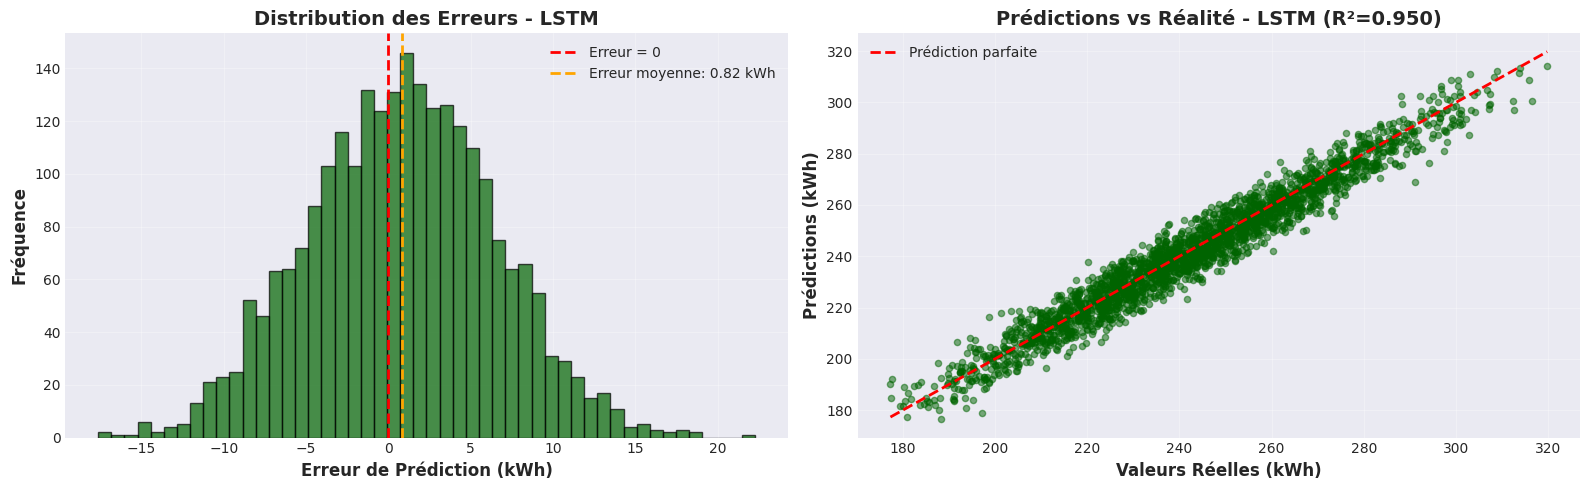

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Vue d'ensemble
axes[0].plot(y_test_original, label='Valeurs Réelles', linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].plot(y_pred_lstm_original, label='Prédictions LSTM', linewidth=1.5, color='darkgreen', alpha=0.8)
axes[0].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('LSTM - Prédictions vs Réalité (Set de Test Complet)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Zoom sur une semaine
zoom_size = 24 * 7
axes[1].plot(range(zoom_size), y_test_original[:zoom_size], 
            label='Valeurs Réelles', linewidth=2, color='steelblue', marker='o', markersize=4)
axes[1].plot(range(zoom_size), y_pred_lstm_original[:zoom_size], 
            label='Prédictions LSTM', linewidth=2, color='darkgreen', marker='s', markersize=4)
axes[1].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('LSTM - Zoom sur 1 Semaine de Prédictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution des erreurs
errors_lstm = y_test_original.flatten() - y_pred_lstm_original.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(errors_lstm, bins=50, color='darkgreen', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
ax1.axvline(x=errors_lstm.mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Erreur moyenne: {errors_lstm.mean():.2f} kWh')
ax1.set_xlabel('Erreur de Prédiction (kWh)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Erreurs - LSTM', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2.scatter(y_test_original, y_pred_lstm_original, alpha=0.5, s=20, color='darkgreen')
ax2.plot([y_test_original.min(), y_test_original.max()], 
        [y_test_original.min(), y_test_original.max()], 
        'r--', linewidth=2, label='Prédiction parfaite')
ax2.set_xlabel('Valeurs Réelles (kWh)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prédictions (kWh)', fontsize=12, fontweight='bold')
ax2.set_title(f'Prédictions vs Réalité - LSTM (R²={r2_lstm:.3f})', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# PARTIE 3 : GRU

## 7. Architecture GRU pour Séries Temporelles

### Avantages du GRU pour les séries temporelles

Le **GRU** est souvent le choix préféré en production pour les séries temporelles :
- ✅ **Performance proche du LSTM** avec moins de paramètres
- ✅ **Entraînement plus rapide** (important pour re-entraînement fréquent)
- ✅ **Moins de risque d'overfitting** sur des datasets limités
- ✅ **Déploiement plus léger** (edge computing, IoT)

### 7.1 Construction du modèle GRU

In [20]:
def create_gru_model(lookback):
    """
    Crée un modèle GRU pour la prédiction de séries temporelles.
    """
    model = keras.Sequential([
        # Couche GRU
        layers.GRU(64, input_shape=(lookback, 1), name='gru'),
        
        # Dropout
        layers.Dropout(0.2, name='dropout'),
        
        # Couche de sortie
        layers.Dense(1, name='output')
    ])
    
    return model

# Création du modèle
gru_model = create_gru_model(LOOKBACK)

# Affichage de l'architecture
gru_model.summary()

# Comptage des paramètres
total_params_gru = gru_model.count_params()
print(f"\n{'='*70}")
print(f"Total de paramètres GRU:  {total_params_gru:,}")
print(f"Ratio GRU/RNN:  {total_params_gru/total_params_rnn:.2f}×")
print(f"Ratio GRU/LSTM: {total_params_gru/total_params_lstm:.2f}× (GRU ~25% plus léger)")
print(f"{'='*70}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)


Total de paramètres GRU:  12,929
Ratio GRU/RNN:  3.01×
Ratio GRU/LSTM: 0.76× (GRU ~25% plus léger)


### 7.2 Compilation et entraînement du modèle GRU

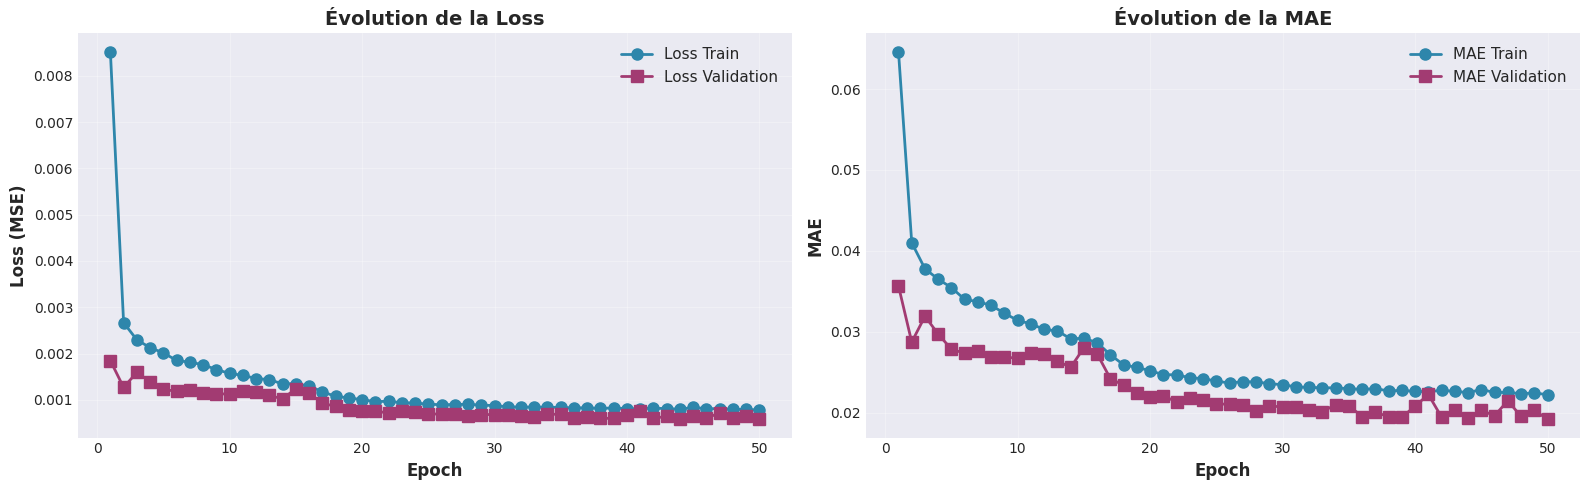


Epoch 50/50
Loss: 0.000782 - MAE: 0.022236
Val Loss: 0.000583 - Val MAE: 0.019196

✅ Entraînement terminé ! (Early stopping à l'epoch 50)


In [21]:
# Compilation
gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("✅ Modèle GRU compilé avec succès !")

# Callbacks
live_plot_gru = LivePlotCallback()
early_stopping_gru = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement
print("\n🚀 Début de l'entraînement du modèle GRU...\n")

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[live_plot_gru, early_stopping_gru],
    verbose=0
)

print(f"\n✅ Entraînement terminé ! (Early stopping à l'epoch {len(history_gru.history['loss'])})")

### 7.3 Évaluation du modèle GRU

In [22]:
# Prédictions
y_pred_gru_scaled = gru_model.predict(X_test, verbose=0)
y_pred_gru_original = scaler.inverse_transform(y_pred_gru_scaled)

# Métriques
mse_gru = mean_squared_error(y_test_original, y_pred_gru_original)
mae_gru = mean_absolute_error(y_test_original, y_pred_gru_original)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_original, y_pred_gru_original)

print("="*70)
print("RÉSULTATS FINAUX - MODÈLE GRU")
print("="*70)
print(f"MSE (Mean Squared Error):  {mse_gru:.2f}")
print(f"MAE (Mean Absolute Error): {mae_gru:.2f} kWh")
print(f"RMSE (Root MSE):           {rmse_gru:.2f} kWh")
print(f"R² Score:                  {r2_gru:.4f}")
print(f"\n📊 Amélioration vs RNN:  {((mae_rnn - mae_gru)/mae_rnn * 100):.1f}% de réduction de la MAE")
print(f"📊 Comparaison vs LSTM: {abs((mae_lstm - mae_gru)/mae_lstm * 100):.1f}% {'meilleur' if mae_gru < mae_lstm else 'moins bon'}")
print("="*70)

RÉSULTATS FINAUX - MODÈLE GRU
MSE (Mean Squared Error):  34.81
MAE (Mean Absolute Error): 4.71 kWh
RMSE (Root MSE):           5.90 kWh
R² Score:                  0.9478

📊 Amélioration vs RNN:  8.4% de réduction de la MAE
📊 Comparaison vs LSTM: 2.1% moins bon


### 7.4 Visualisation des prédictions GRU

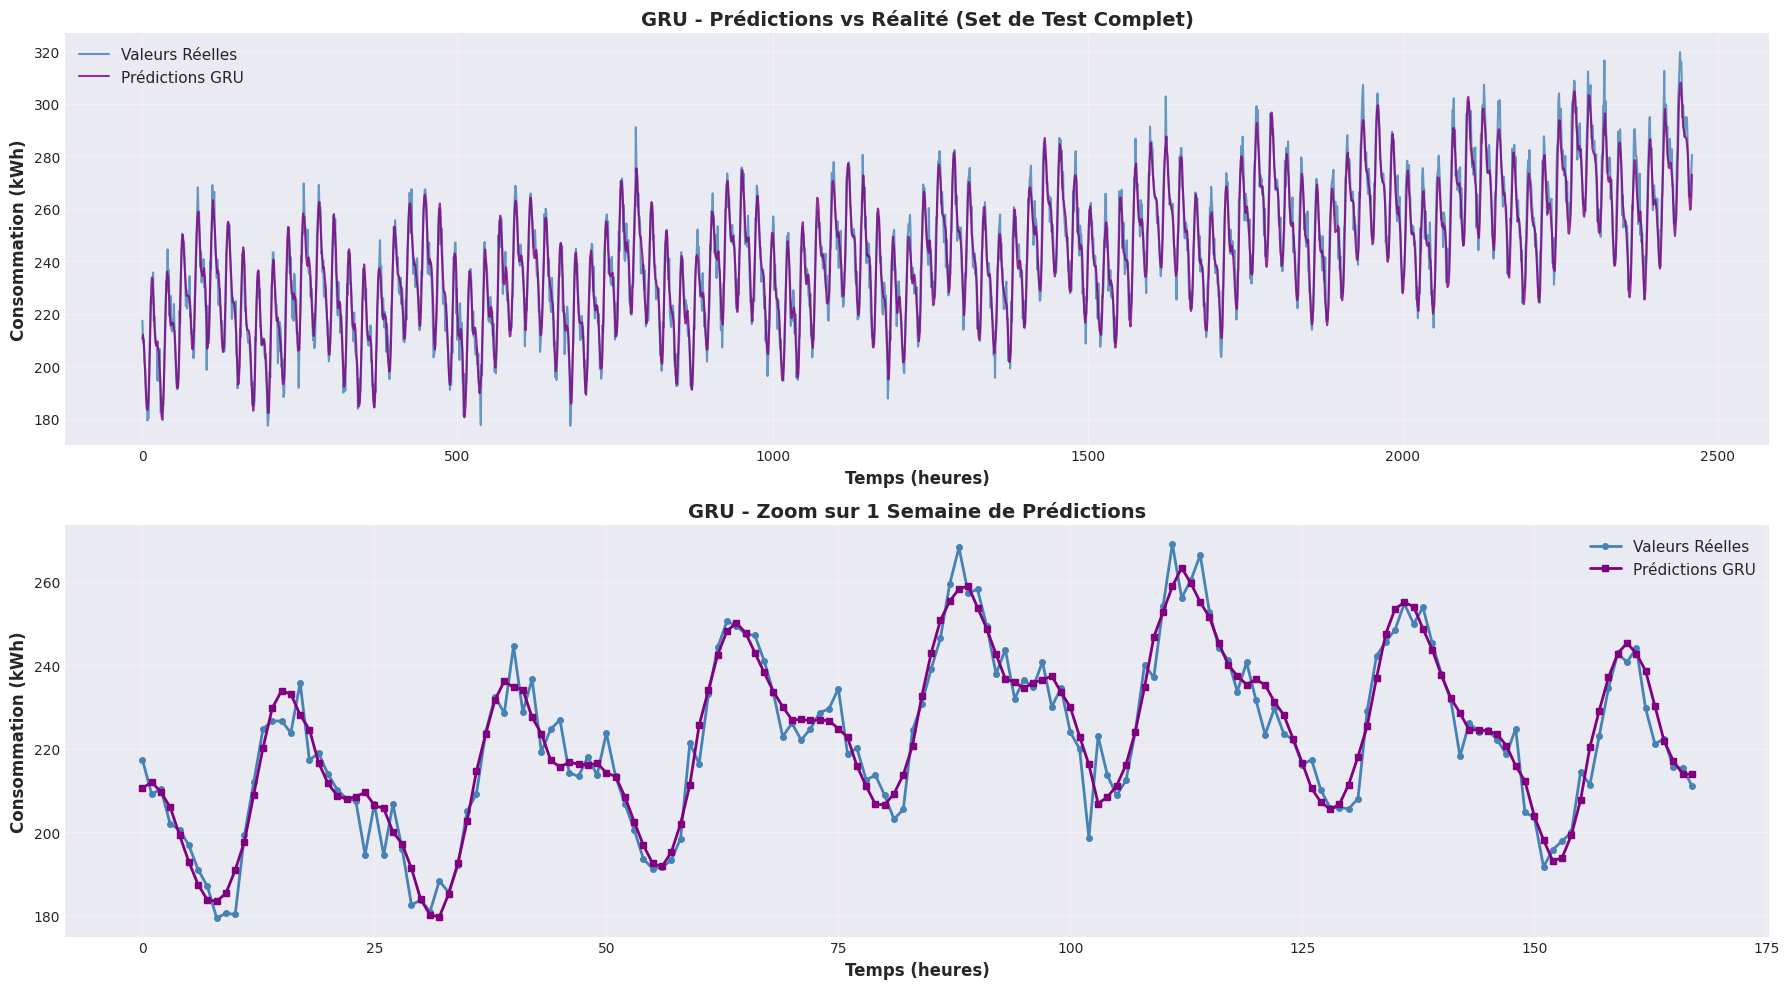

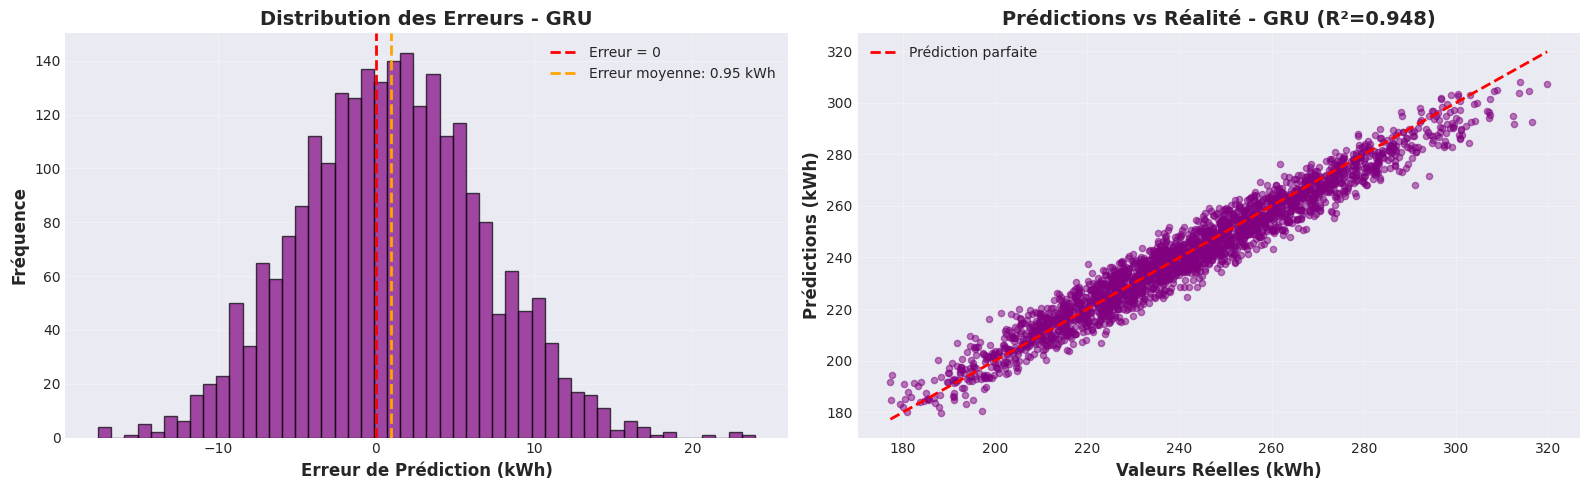

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Vue d'ensemble
axes[0].plot(y_test_original, label='Valeurs Réelles', linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].plot(y_pred_gru_original, label='Prédictions GRU', linewidth=1.5, color='purple', alpha=0.8)
axes[0].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[0].set_title('GRU - Prédictions vs Réalité (Set de Test Complet)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Zoom sur une semaine
zoom_size = 24 * 7
axes[1].plot(range(zoom_size), y_test_original[:zoom_size], 
            label='Valeurs Réelles', linewidth=2, color='steelblue', marker='o', markersize=4)
axes[1].plot(range(zoom_size), y_pred_gru_original[:zoom_size], 
            label='Prédictions GRU', linewidth=2, color='purple', marker='s', markersize=4)
axes[1].set_xlabel('Temps (heures)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
axes[1].set_title('GRU - Zoom sur 1 Semaine de Prédictions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution des erreurs
errors_gru = y_test_original.flatten() - y_pred_gru_original.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.hist(errors_gru, bins=50, color='purple', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
ax1.axvline(x=errors_gru.mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Erreur moyenne: {errors_gru.mean():.2f} kWh')
ax1.set_xlabel('Erreur de Prédiction (kWh)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Erreurs - GRU', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2.scatter(y_test_original, y_pred_gru_original, alpha=0.5, s=20, color='purple')
ax2.plot([y_test_original.min(), y_test_original.max()], 
        [y_test_original.min(), y_test_original.max()], 
        'r--', linewidth=2, label='Prédiction parfaite')
ax2.set_xlabel('Valeurs Réelles (kWh)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Prédictions (kWh)', fontsize=12, fontweight='bold')
ax2.set_title(f'Prédictions vs Réalité - GRU (R²={r2_gru:.3f})', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 8. COMPARAISON FINALE : RNN vs LSTM vs GRU

### 8.1 Tableau comparatif des performances

In [24]:
# Tableau comparatif
comparison_data = {
    'Métrique': ['MAE (kWh)', 'RMSE (kWh)', 'R² Score', 'Paramètres', 'Epochs (Early Stop)'],
    'RNN Simple': [
        f"{mae_rnn:.2f}",
        f"{rmse_rnn:.2f}",
        f"{r2_rnn:.4f}",
        f"{total_params_rnn:,}",
        f"{len(history_rnn.history['loss'])}"
    ],
    'LSTM': [
        f"{mae_lstm:.2f}",
        f"{rmse_lstm:.2f}",
        f"{r2_lstm:.4f}",
        f"{total_params_lstm:,}",
        f"{len(history_lstm.history['loss'])}"
    ],
    'GRU': [
        f"{mae_gru:.2f}",
        f"{rmse_gru:.2f}",
        f"{r2_gru:.4f}",
        f"{total_params_gru:,}",
        f"{len(history_gru.history['loss'])}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARAISON FINALE : RNN vs LSTM vs GRU - Séries Temporelles")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Détermination du meilleur modèle
maes = [mae_rnn, mae_lstm, mae_gru]
model_names = ['RNN', 'LSTM', 'GRU']
best_idx = np.argmin(maes)
print(f"\n🏆 Meilleur modèle en MAE : {model_names[best_idx]} ({maes[best_idx]:.2f} kWh)")

r2s = [r2_rnn, r2_lstm, r2_gru]
best_r2_idx = np.argmax(r2s)
print(f"🏆 Meilleur modèle en R² : {model_names[best_r2_idx]} ({r2s[best_r2_idx]:.4f})")


COMPARAISON FINALE : RNN vs LSTM vs GRU - Séries Temporelles
           Métrique RNN Simple   LSTM    GRU
          MAE (kWh)       5.14   4.61   4.71
         RMSE (kWh)       6.45   5.75   5.90
           R² Score     0.9376 0.9505 0.9478
         Paramètres      4,289 16,961 12,929
Epochs (Early Stop)         15     50     50

🏆 Meilleur modèle en MAE : LSTM (4.61 kWh)
🏆 Meilleur modèle en R² : LSTM (0.9505)


### 8.2 Visualisation comparative des prédictions

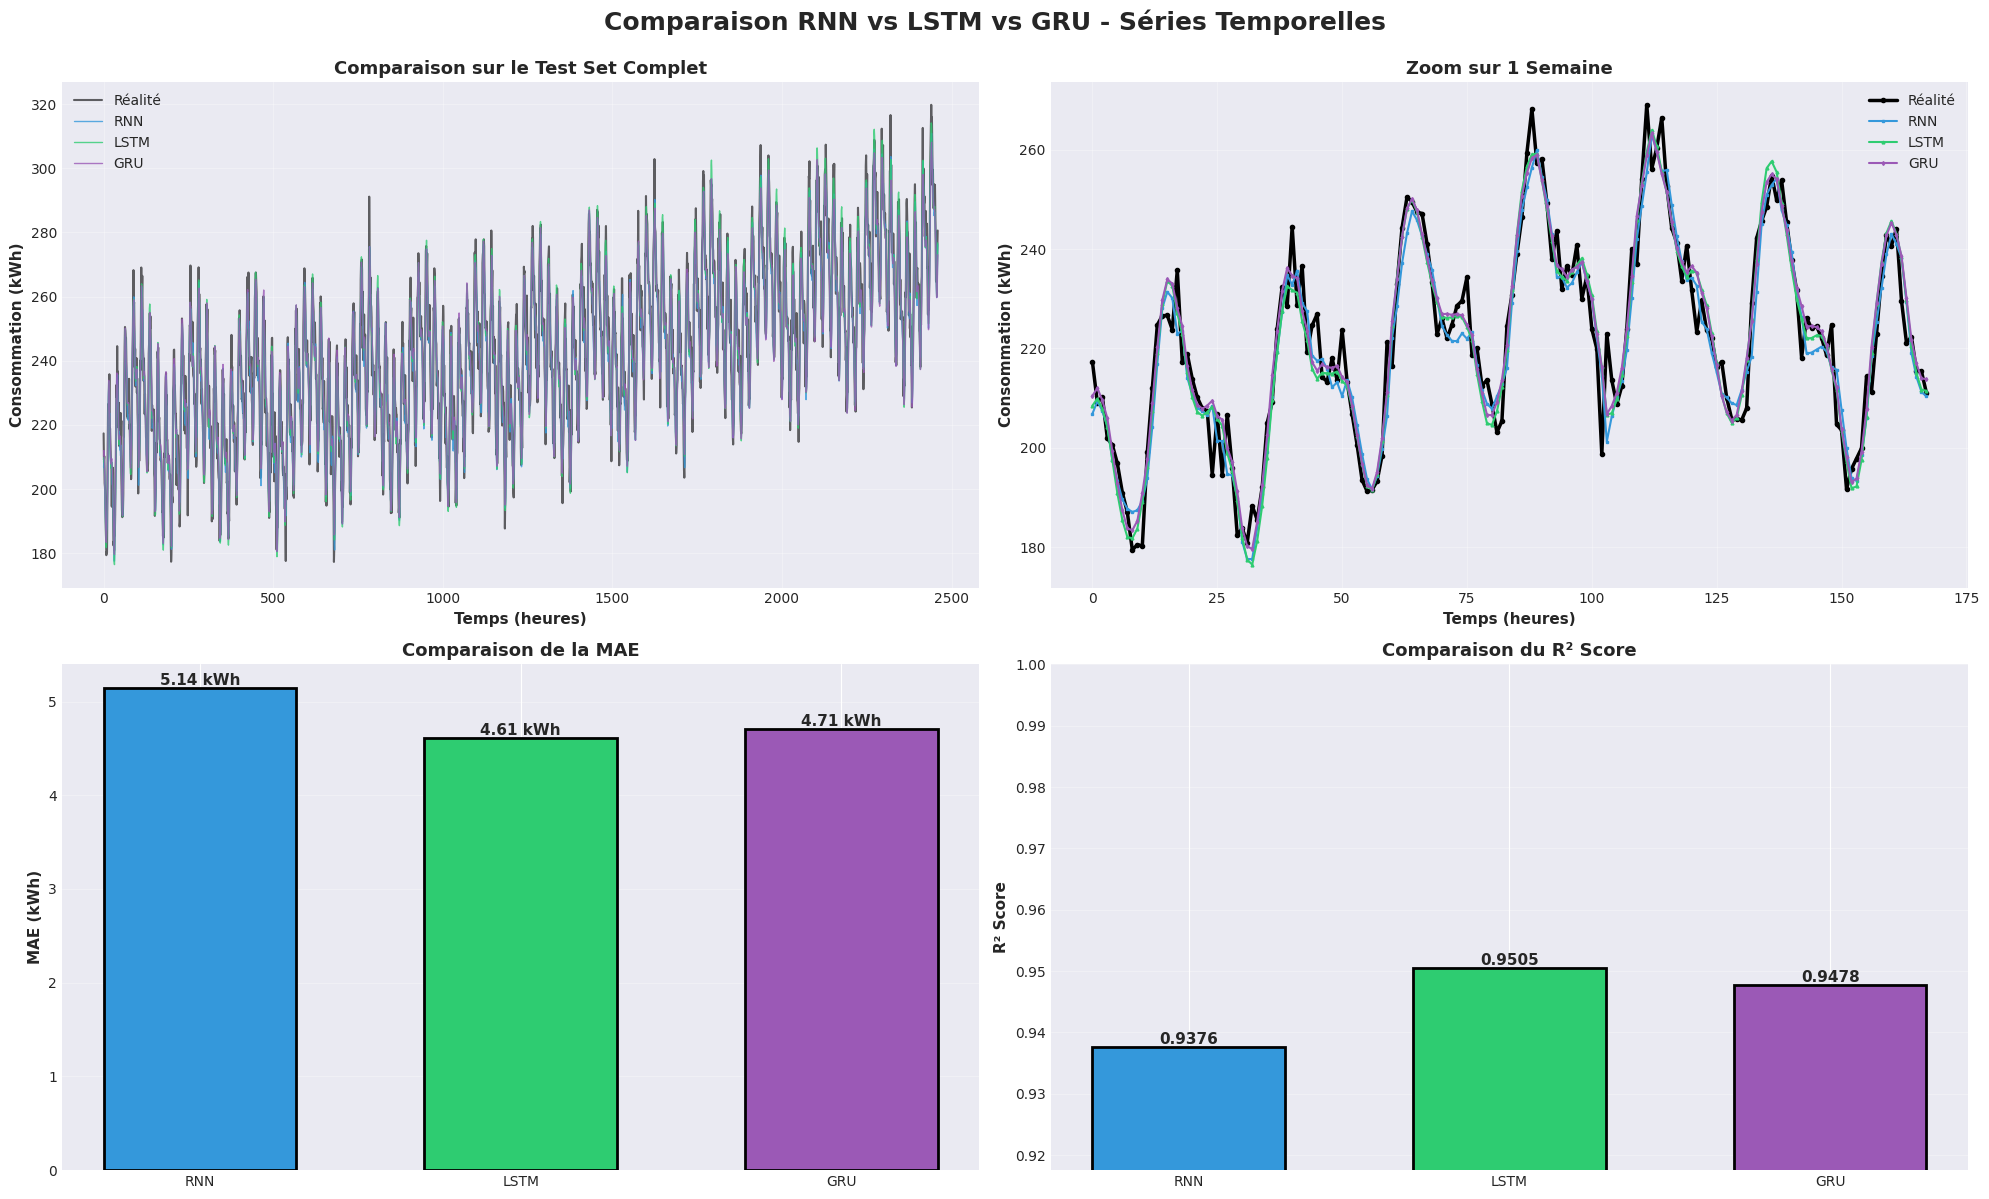

In [25]:
# Comparaison visuelle sur une semaine
zoom_size = 24 * 7  # 1 semaine

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Comparaison RNN vs LSTM vs GRU - Séries Temporelles', 
            fontsize=18, fontweight='bold', y=0.995)

# Vue complète
axes[0, 0].plot(y_test_original, label='Réalité', linewidth=1.5, color='black', alpha=0.6)
axes[0, 0].plot(y_pred_rnn_original, label='RNN', linewidth=1, color='#3498db', alpha=0.8)
axes[0, 0].plot(y_pred_lstm_original, label='LSTM', linewidth=1, color='#2ecc71', alpha=0.8)
axes[0, 0].plot(y_pred_gru_original, label='GRU', linewidth=1, color='#9b59b6', alpha=0.8)
axes[0, 0].set_xlabel('Temps (heures)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Consommation (kWh)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Comparaison sur le Test Set Complet', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3)

# Zoom sur 1 semaine
axes[0, 1].plot(range(zoom_size), y_test_original[:zoom_size], 
               label='Réalité', linewidth=2.5, color='black', marker='o', markersize=3)
axes[0, 1].plot(range(zoom_size), y_pred_rnn_original[:zoom_size], 
               label='RNN', linewidth=1.5, color='#3498db', marker='s', markersize=2)
axes[0, 1].plot(range(zoom_size), y_pred_lstm_original[:zoom_size], 
               label='LSTM', linewidth=1.5, color='#2ecc71', marker='^', markersize=2)
axes[0, 1].plot(range(zoom_size), y_pred_gru_original[:zoom_size], 
               label='GRU', linewidth=1.5, color='#9b59b6', marker='d', markersize=2)
axes[0, 1].set_xlabel('Temps (heures)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Consommation (kWh)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Zoom sur 1 Semaine', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(alpha=0.3)

# Comparaison des MAE
models = ['RNN', 'LSTM', 'GRU']
maes_list = [mae_rnn, mae_lstm, mae_gru]
colors = ['#3498db', '#2ecc71', '#9b59b6']
bars = axes[1, 0].bar(models, maes_list, color=colors, edgecolor='black', linewidth=2, width=0.6)
axes[1, 0].set_ylabel('MAE (kWh)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Comparaison de la MAE', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')
for bar, mae in zip(bars, maes_list):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{mae:.2f} kWh',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

# Comparaison des R²
r2s_list = [r2_rnn, r2_lstm, r2_gru]
bars2 = axes[1, 1].bar(models, r2s_list, color=colors, edgecolor='black', linewidth=2, width=0.6)
axes[1, 1].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Comparaison du R² Score', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([min(r2s_list) - 0.02, 1.0])
axes[1, 1].grid(alpha=0.3, axis='y')
for bar, r2 in zip(bars2, r2s_list):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{r2:.4f}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 8.3 Comparaison des courbes d'apprentissage

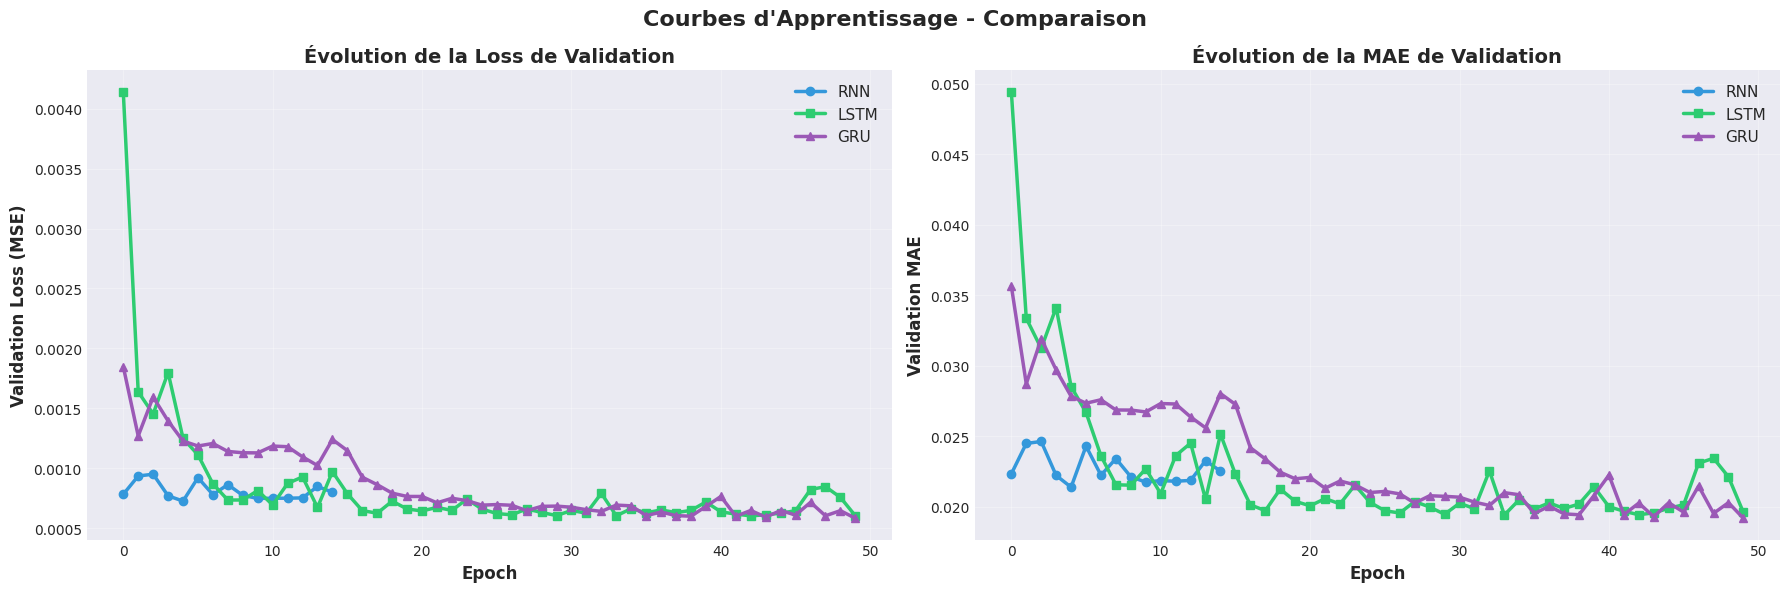

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Courbes d\'Apprentissage - Comparaison', fontsize=16, fontweight='bold')

colors_comp = ['#3498db', '#2ecc71', '#9b59b6']

# Loss de validation
axes[0].plot(history_rnn.history['val_loss'], 'o-', label='RNN', 
            linewidth=2.5, markersize=6, color=colors_comp[0])
axes[0].plot(history_lstm.history['val_loss'], 's-', label='LSTM', 
            linewidth=2.5, markersize=6, color=colors_comp[1])
axes[0].plot(history_gru.history['val_loss'], '^-', label='GRU', 
            linewidth=2.5, markersize=6, color=colors_comp[2])
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Évolution de la Loss de Validation', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# MAE de validation
axes[1].plot(history_rnn.history['val_mae'], 'o-', label='RNN', 
            linewidth=2.5, markersize=6, color=colors_comp[0])
axes[1].plot(history_lstm.history['val_mae'], 's-', label='LSTM', 
            linewidth=2.5, markersize=6, color=colors_comp[1])
axes[1].plot(history_gru.history['val_mae'], '^-', label='GRU', 
            linewidth=2.5, markersize=6, color=colors_comp[2])
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
axes[1].set_title('Évolution de la MAE de Validation', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Prédiction Multi-Step (Bonus)

### Prédire plusieurs heures à l'avance

Dans la pratique, on veut souvent prédire **plusieurs timesteps futurs** :
- Prédire les 24 prochaines heures
- Prédire la semaine suivante

**Méthodes** :
1. **Recursive** : Prédire t+1, puis utiliser cette prédiction pour prédire t+2, etc.
2. **Direct** : Entraîner un modèle séparé pour chaque horizon
3. **Multi-output** : Un seul modèle qui prédit tous les horizons simultanément

Testons l'approche **recursive** avec le meilleur modèle.

Utilisation du modèle LSTM pour la prédiction multi-step



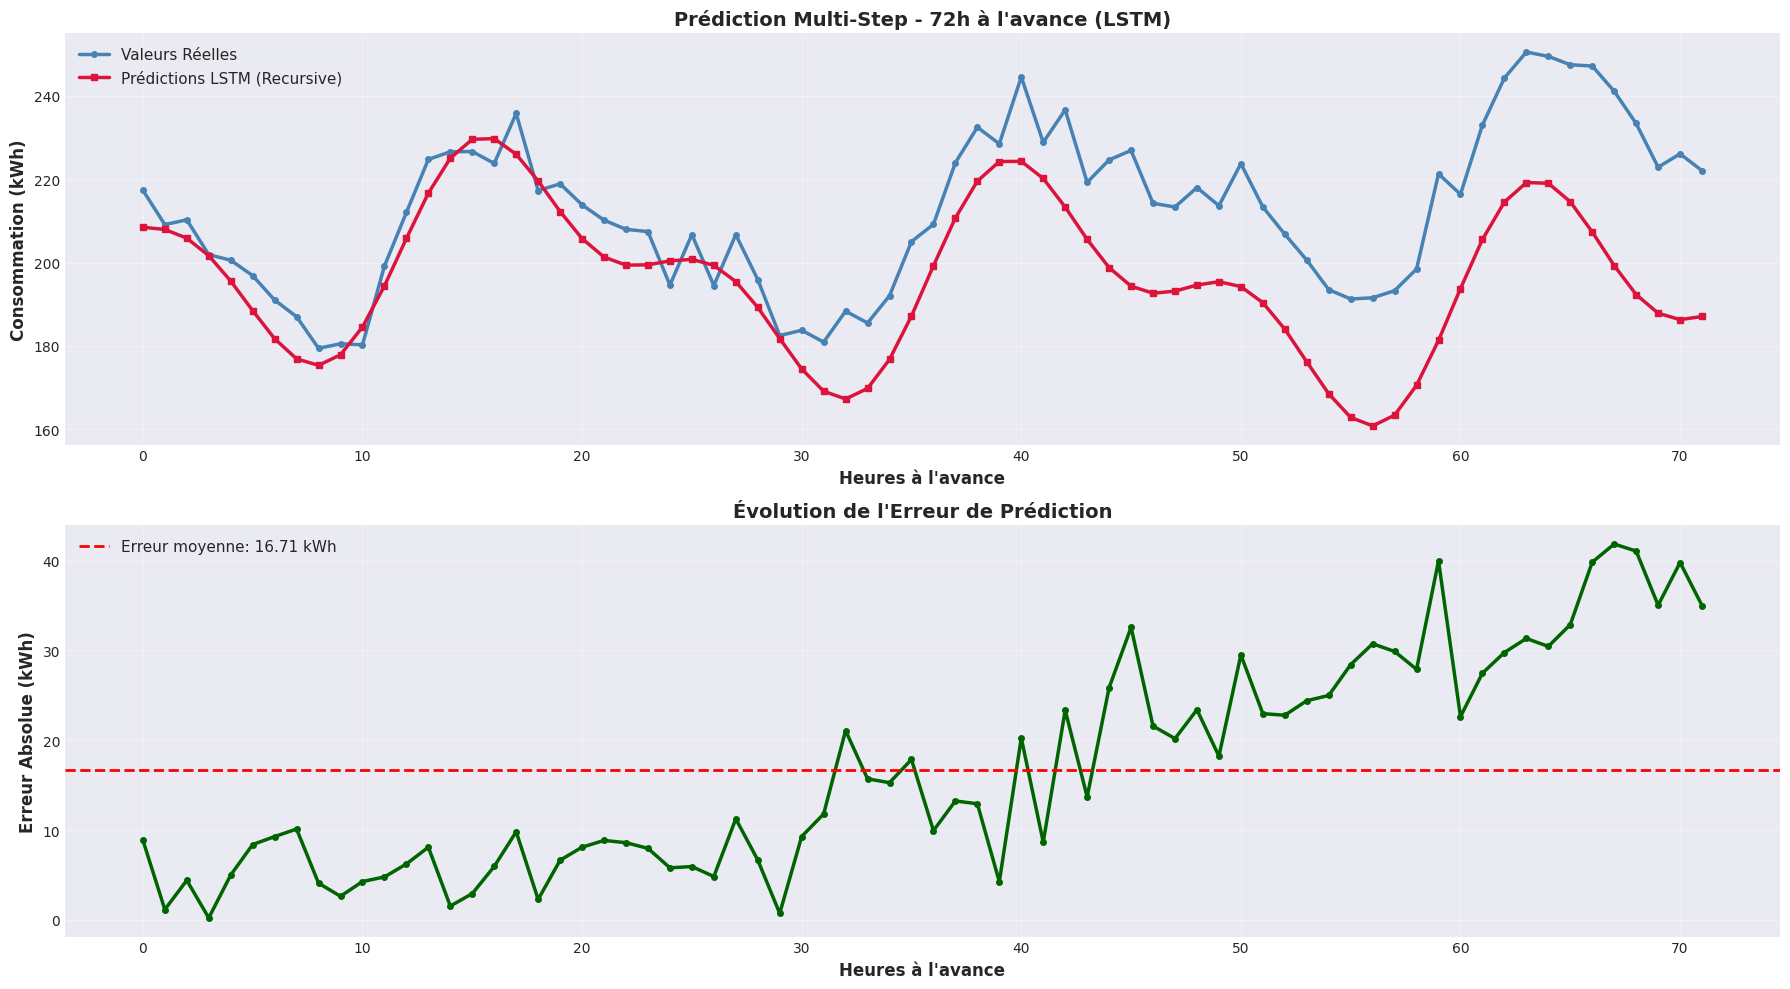


📊 MAE pour la prédiction 72h à l'avance: 16.71 kWh
📊 Dégradation vs prédiction 1h: 262.5%

⚠️  Note: L'erreur augmente avec l'horizon de prédiction (effet cumulatif)


In [27]:
def predict_multi_step(model, initial_sequence, n_steps, scaler):
    """
    Prédit n_steps à l'avance de manière récursive.
    
    Args:
        model: Modèle entraîné
        initial_sequence: Séquence initiale normalisée (lookback, 1)
        n_steps: Nombre d'étapes à prédire
        scaler: Scaler pour dénormalisation
    
    Returns:
        Prédictions dénormalisées
    """
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(n_steps):
        # Prédire le prochain timestep
        current_input = current_sequence.reshape(1, LOOKBACK, 1)
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(next_pred)
        
        # Mettre à jour la séquence (glisser la fenêtre)
        current_sequence = np.append(current_sequence[1:], next_pred)
    
    # Dénormaliser
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_original = scaler.inverse_transform(predictions)
    
    return predictions_original.flatten()

# Choisir le meilleur modèle
if mae_gru <= mae_lstm and mae_gru <= mae_rnn:
    best_model = gru_model
    best_name = 'GRU'
elif mae_lstm <= mae_rnn:
    best_model = lstm_model
    best_name = 'LSTM'
else:
    best_model = rnn_model
    best_name = 'RNN'

print(f"Utilisation du modèle {best_name} pour la prédiction multi-step\n")

# Prédire les 72 prochaines heures (3 jours)
n_future_steps = 72
start_idx = 0

initial_seq = X_test[start_idx].flatten()
predictions_future = predict_multi_step(best_model, initial_seq, n_future_steps, scaler)

# Valeurs réelles correspondantes
actual_future = y_test_original[start_idx:start_idx+n_future_steps].flatten()

# Visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

# Prédiction 72h à l'avance
time_range = range(n_future_steps)
ax1.plot(time_range, actual_future, label='Valeurs Réelles', 
        linewidth=2.5, color='steelblue', marker='o', markersize=4)
ax1.plot(time_range, predictions_future, label=f'Prédictions {best_name} (Recursive)', 
        linewidth=2.5, color='crimson', marker='s', markersize=4)
ax1.set_xlabel('Heures à l\'avance', fontsize=12, fontweight='bold')
ax1.set_ylabel('Consommation (kWh)', fontsize=12, fontweight='bold')
ax1.set_title(f'Prédiction Multi-Step - {n_future_steps}h à l\'avance ({best_name})', 
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Erreur cumulative
errors_cumulative = np.abs(actual_future - predictions_future)
ax2.plot(time_range, errors_cumulative, linewidth=2.5, color='darkgreen', marker='o', markersize=4)
ax2.axhline(y=errors_cumulative.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Erreur moyenne: {errors_cumulative.mean():.2f} kWh')
ax2.set_xlabel('Heures à l\'avance', fontsize=12, fontweight='bold')
ax2.set_ylabel('Erreur Absolue (kWh)', fontsize=12, fontweight='bold')
ax2.set_title('Évolution de l\'Erreur de Prédiction', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

mae_multistep = mean_absolute_error(actual_future, predictions_future)
print(f"\n📊 MAE pour la prédiction {n_future_steps}h à l'avance: {mae_multistep:.2f} kWh")
print(f"📊 Dégradation vs prédiction 1h: {((mae_multistep - eval(f'mae_{best_name.lower()}')) / eval(f'mae_{best_name.lower()}') * 100):.1f}%")
print(f"\n⚠️  Note: L'erreur augmente avec l'horizon de prédiction (effet cumulatif)")

## 10. Conclusion et Points Clés

### 📚 Ce que nous avons appris

#### 1. **Préparation des Données pour Séries Temporelles**
- ✅ Fenêtre glissante (sliding window) pour créer les séquences
- ✅ Normalisation essentielle pour les RNN
- ✅ Split temporel (pas de shuffle !)
- ✅ Lookback = compromis entre contexte et complexité

#### 2. **RNN Simple**
- ✅ Architecture de base, rapide à entraîner
- ✅ Fonctionne bien sur séquences courtes avec patterns simples
- ❌ Difficulté avec dépendances à long terme
- ❌ Gradient qui disparaît sur longues séquences

#### 3. **LSTM**
- ✅ Excellente capture des dépendances temporelles longues
- ✅ Gère les tendances et saisonnalités complexes
- ✅ Architecture de référence pour séries temporelles
- ❌ Plus de paramètres = risque d'overfitting
- ❌ Entraînement plus lent

#### 4. **GRU**
- ✅ Performance comparable au LSTM
- ✅ Moins de paramètres (~25% de moins)
- ✅ Plus rapide à entraîner et à déployer
- ✅ **Choix recommandé pour la production**

### 🎯 Recommandations Pratiques

| Situation | Recommandation |
|-----------|----------------|
| **Prototypage rapide** | GRU (meilleur rapport perf/vitesse) |
| **Données limitées** | RNN ou GRU (moins de risque d'overfitting) |
| **Patterns complexes** | LSTM (meilleure capacité d'apprentissage) |
| **Production/Edge** | GRU (léger et rapide) |
| **Prédiction temps réel** | GRU (inférence rapide) |
| **Lookback court (<24h)** | RNN peut suffire |
| **Lookback long (>1 semaine)** | LSTM ou GRU obligatoire |

### 🔧 Optimisations Possibles

1. **Architecture** :
   - Bidirectional RNN/LSTM/GRU
   - Stacked layers (2-3 couches récurrentes)
   - Residual connections
   - Attention mechanisms

2. **Features** :
   - Ajout de features temporelles (heure, jour, mois)
   - Features externes (température, jours fériés)
   - Lags multiples

3. **Entraînement** :
   - Learning rate scheduling
   - Augmentation de données temporelles
   - Cross-validation temporelle (Time Series Split)

### 🚀 Pour Aller Plus Loin

**Architectures modernes** :
- **Temporal Convolutional Networks (TCN)** : CNN 1D pour séries temporelles
- **Transformers** : Attention-based models (Temporal Fusion Transformer)
- **N-BEATS** : Architecture spécialisée pour forecasting
- **Prophet / NeuralProphet** : Modèles de Meta pour séries temporelles

**Techniques avancées** :
- Prédiction probabiliste (quantiles, intervalles de confiance)
- Détection d'anomalies temporelles
- Multi-variate forecasting
- Transfer learning sur séries temporelles

### 💡 Message Final

**Les RNN/LSTM/GRU sont des outils puissants pour les séries temporelles** :
- Ils capturent naturellement les dépendances temporelles
- Le **GRU** offre le meilleur compromis en production
- Les **LSTM** restent la référence pour les patterns complexes
- La **préparation des données** est cruciale (normalisation, lookback)

**Note importante** : Les Transformers commencent à dominer même les séries temporelles, mais les RNN/LSTM/GRU restent pertinents car :
- ✅ Plus légers et rapides
- ✅ Nécessitent moins de données
- ✅ Excellents pour l'edge computing / IoT
- ✅ Interprétabilité supérieure

## 11. Exercices Pratiques

### Exercice 1 : Modifier le Lookback
- Testez avec un lookback de 24h (1 jour) vs 336h (2 semaines)
- Comparez les performances et le temps d'entraînement

### Exercice 2 : Architecture Bidirectionnelle
- Modifiez le GRU pour utiliser `Bidirectional(GRU(64))`
- Est-ce que cela améliore les performances sur ce problème ?

### Exercice 3 : Features Supplémentaires
- Ajoutez l'heure du jour et le jour de la semaine comme features
- Modifiez l'architecture pour accepter 3 features au lieu de 1

### Exercice 4 : Stacked RNN
- Créez un modèle avec 2 couches GRU empilées
- Utilisez `return_sequences=True` sur la première couche

### Exercice 5 : Autre Série Temporelle
- Appliquez ces techniques sur vos propres données
- Prix d'actions, température, trafic réseau, etc.